# 응용통계학 (11주차) 5월 12일
> GLM, 일반화선형모형

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Applied Statistics, GLM, 일반화 선형 모형]

In [1]:
#hide
options(jupyter.plot_scale=4)
options(repr.plot.width=8,repr.plot.height=6,repr.plot.res=300)
#options(jupyter.rich_display=FALSE)
#options(max.print=1000)


다중공선성이 존재하는 상황을 가정하고 

 

다중공선성을 어느 정도 제거한 모형 (M1)과 다중공선성이 내재되어 있는 모형 (M2) 을 고려하여

 

두 모형의 예측력을 모의실험을 통해 비교하여라,

 

단, 실험은 여러 번 반복하여 평균적인 결과를  report하되 설명변수의 개수는 3개 이상으로 설정하여라.

 

이미 존재하는 문서들을 참고하거나 재현해도 무방함.

 

(첨부된 문서 참고)

# 일반화선형모형 : Generalized linear model I

이 강의노트는 `Extending the linear model with R` (2016), 2nd edition, Julian J. Faraway, Chapman and Hall. 을 바탕으로 작성되었습니다.

## 1. Binary response

### 1.1 Heart Disease Example

샌프란시스코에 사는 39세에서 59세 사이의 건강한 성인남성 3154명에 대하여 8년 반 동안 관찰하여 심장관상동맥질환이 나타났는지 여부를 관찰하였다.

여기서 target 변수 `chd` ; coronary heat disease developed 는 factor변수로 취급할 수 있고 `no` `yes` 두 수준을 가진다. 다른 요인들이 질환여부와 어떻게 연관되는지를 알고자 한다면 target 변수가 연속이 아닌 이진(binary)형이므로 지금까지 다루었던 전형적인 선형모형은 적합하지 않다.
- no: 0, yes: 1

$$chd∼height+cigarette$$
- 담배는 하루에 몇 개피 피웠는지
- $y = \beta_0 + \beta_1 h + \beta_2 c + \epsilon$
- $\beta_0, \beta_1, \beta_2 \in R$

몇 가지 그림을 통해 자료를 살펴보자.

- 연속형에서는 산점도, 이진형에서는 박스플랏?!

In [2]:
data(wcgs, package="faraway")
summary(wcgs[,c("chd","height","cigs")])

  chd           height           cigs     
 no :2897   Min.   :60.00   Min.   : 0.0  
 yes: 257   1st Qu.:68.00   1st Qu.: 0.0  
            Median :70.00   Median : 0.0  
            Mean   :69.78   Mean   :11.6  
            3rd Qu.:72.00   3rd Qu.:20.0  
            Max.   :78.00   Max.   :99.0  

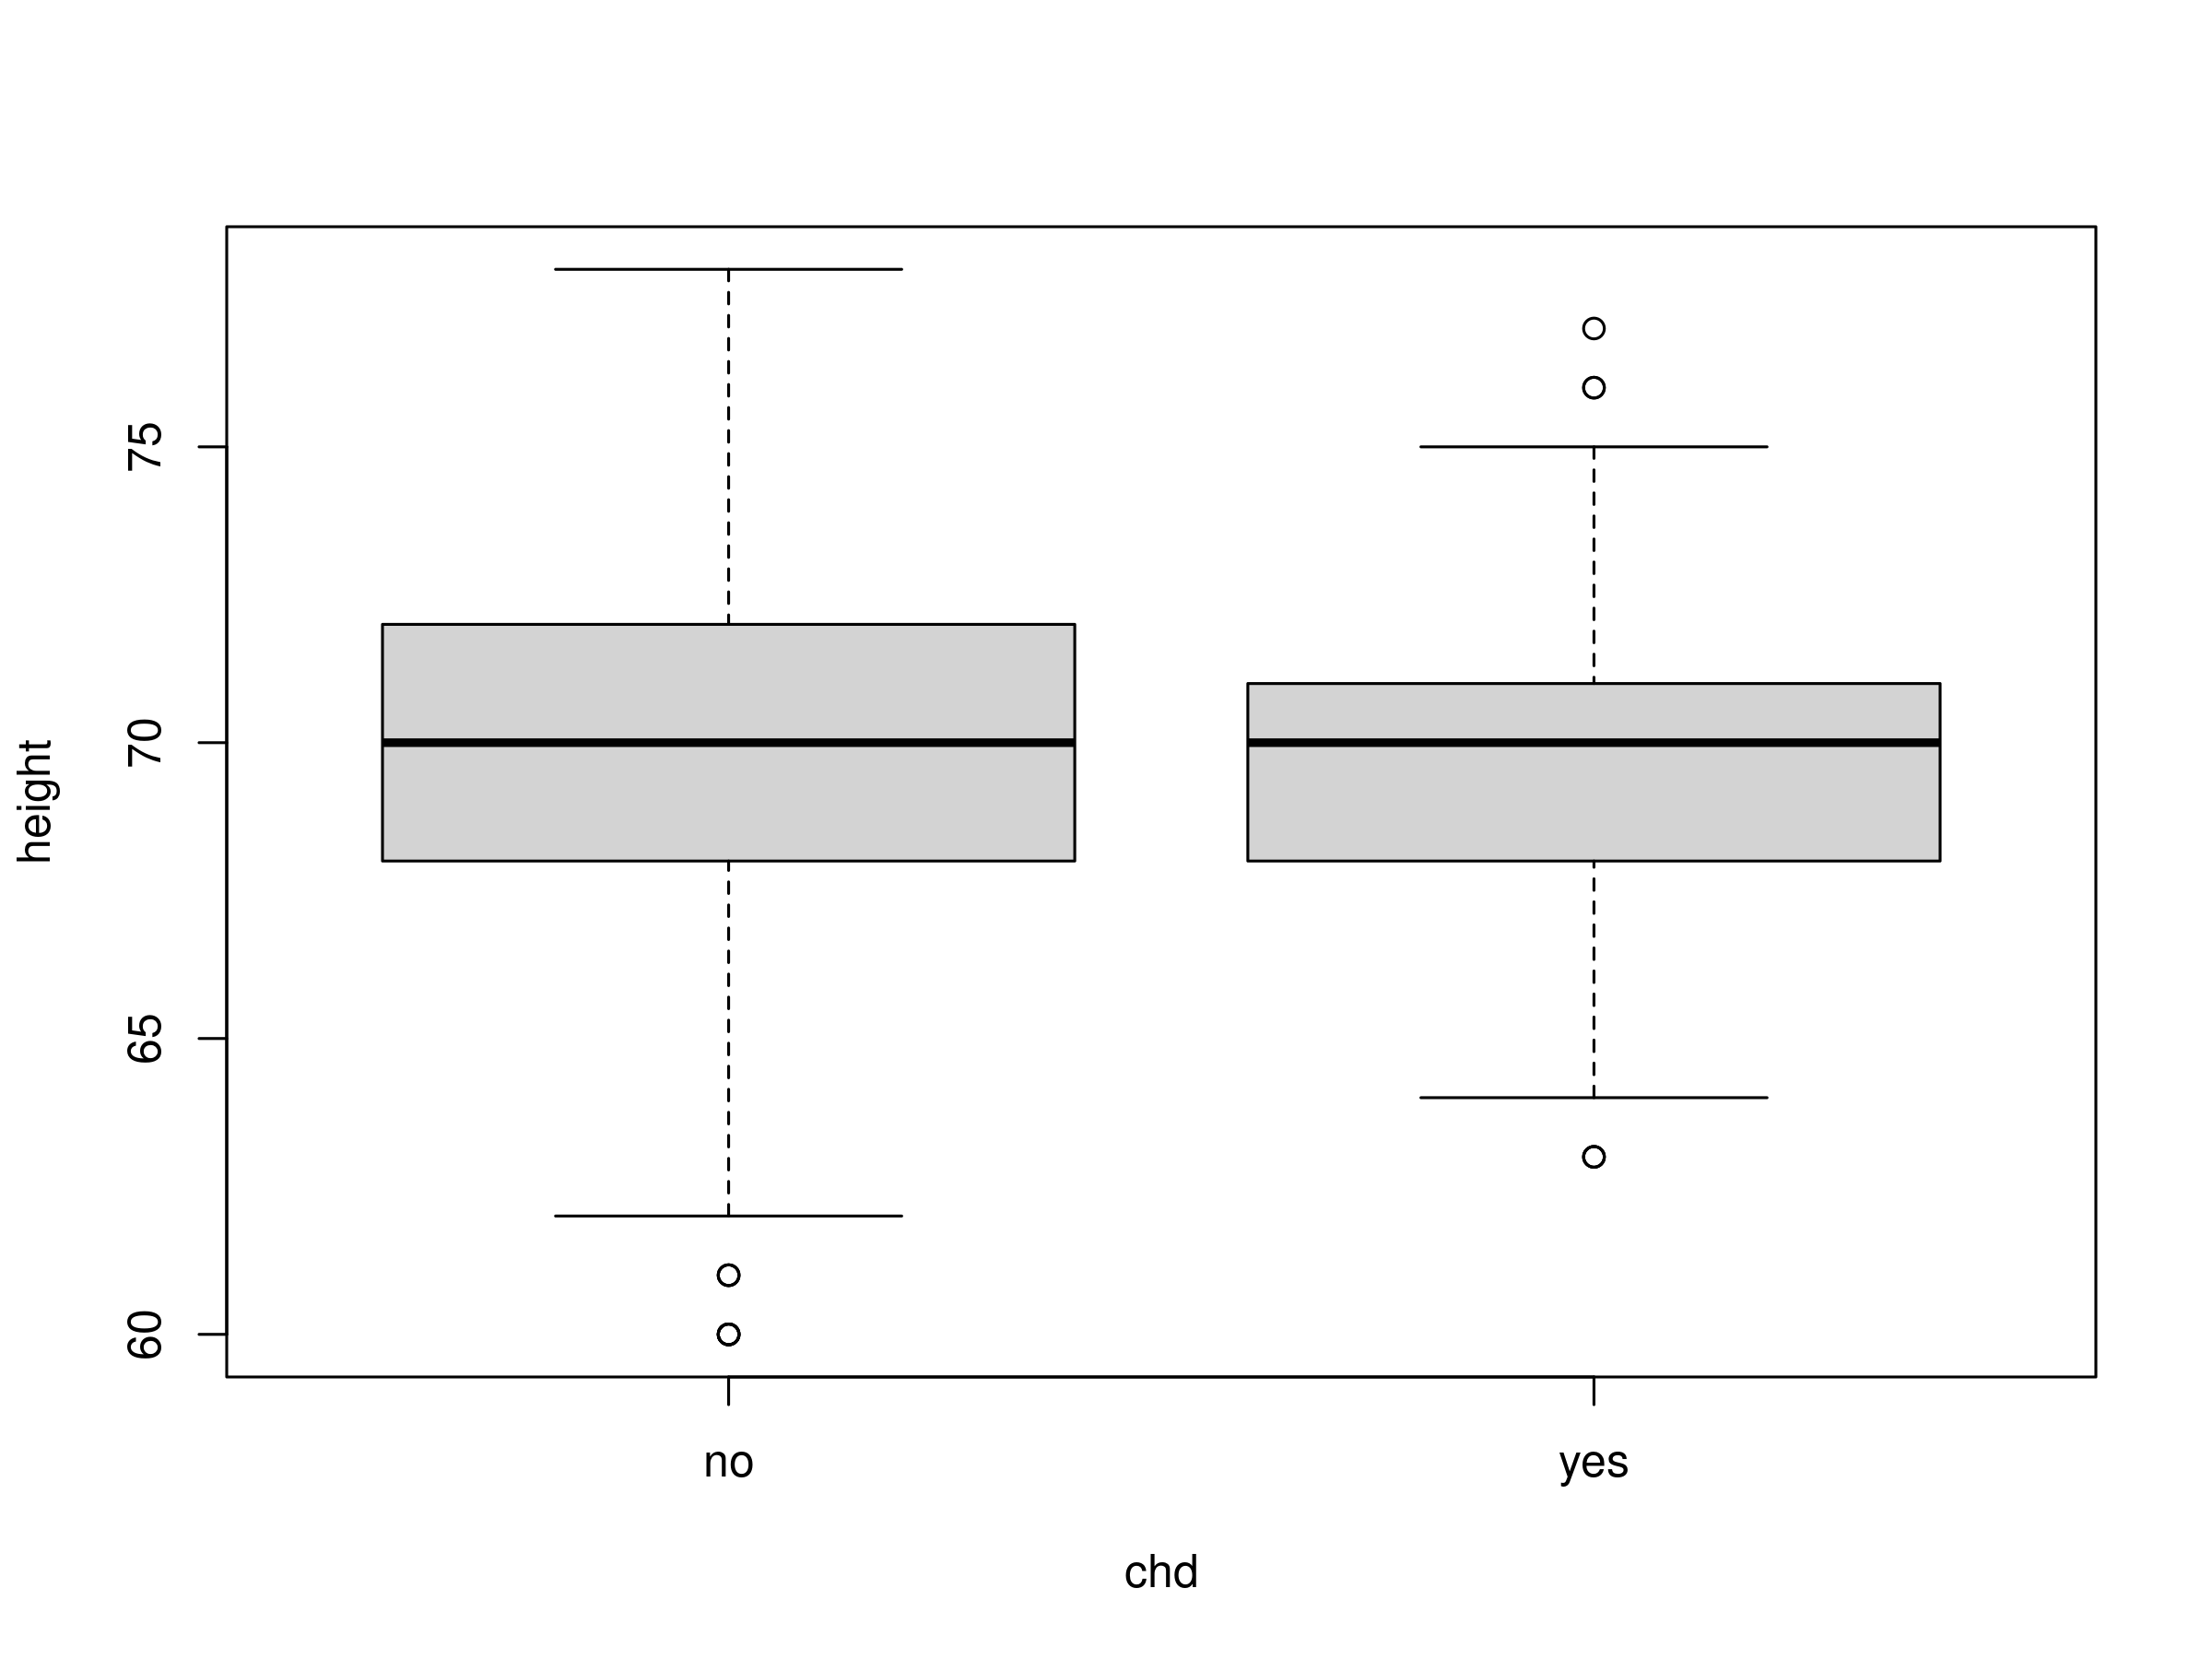

In [3]:
plot(height ~ chd, wcgs)

- 키가 작으면 질병이 걸리는 건가? 명확하진 않다.

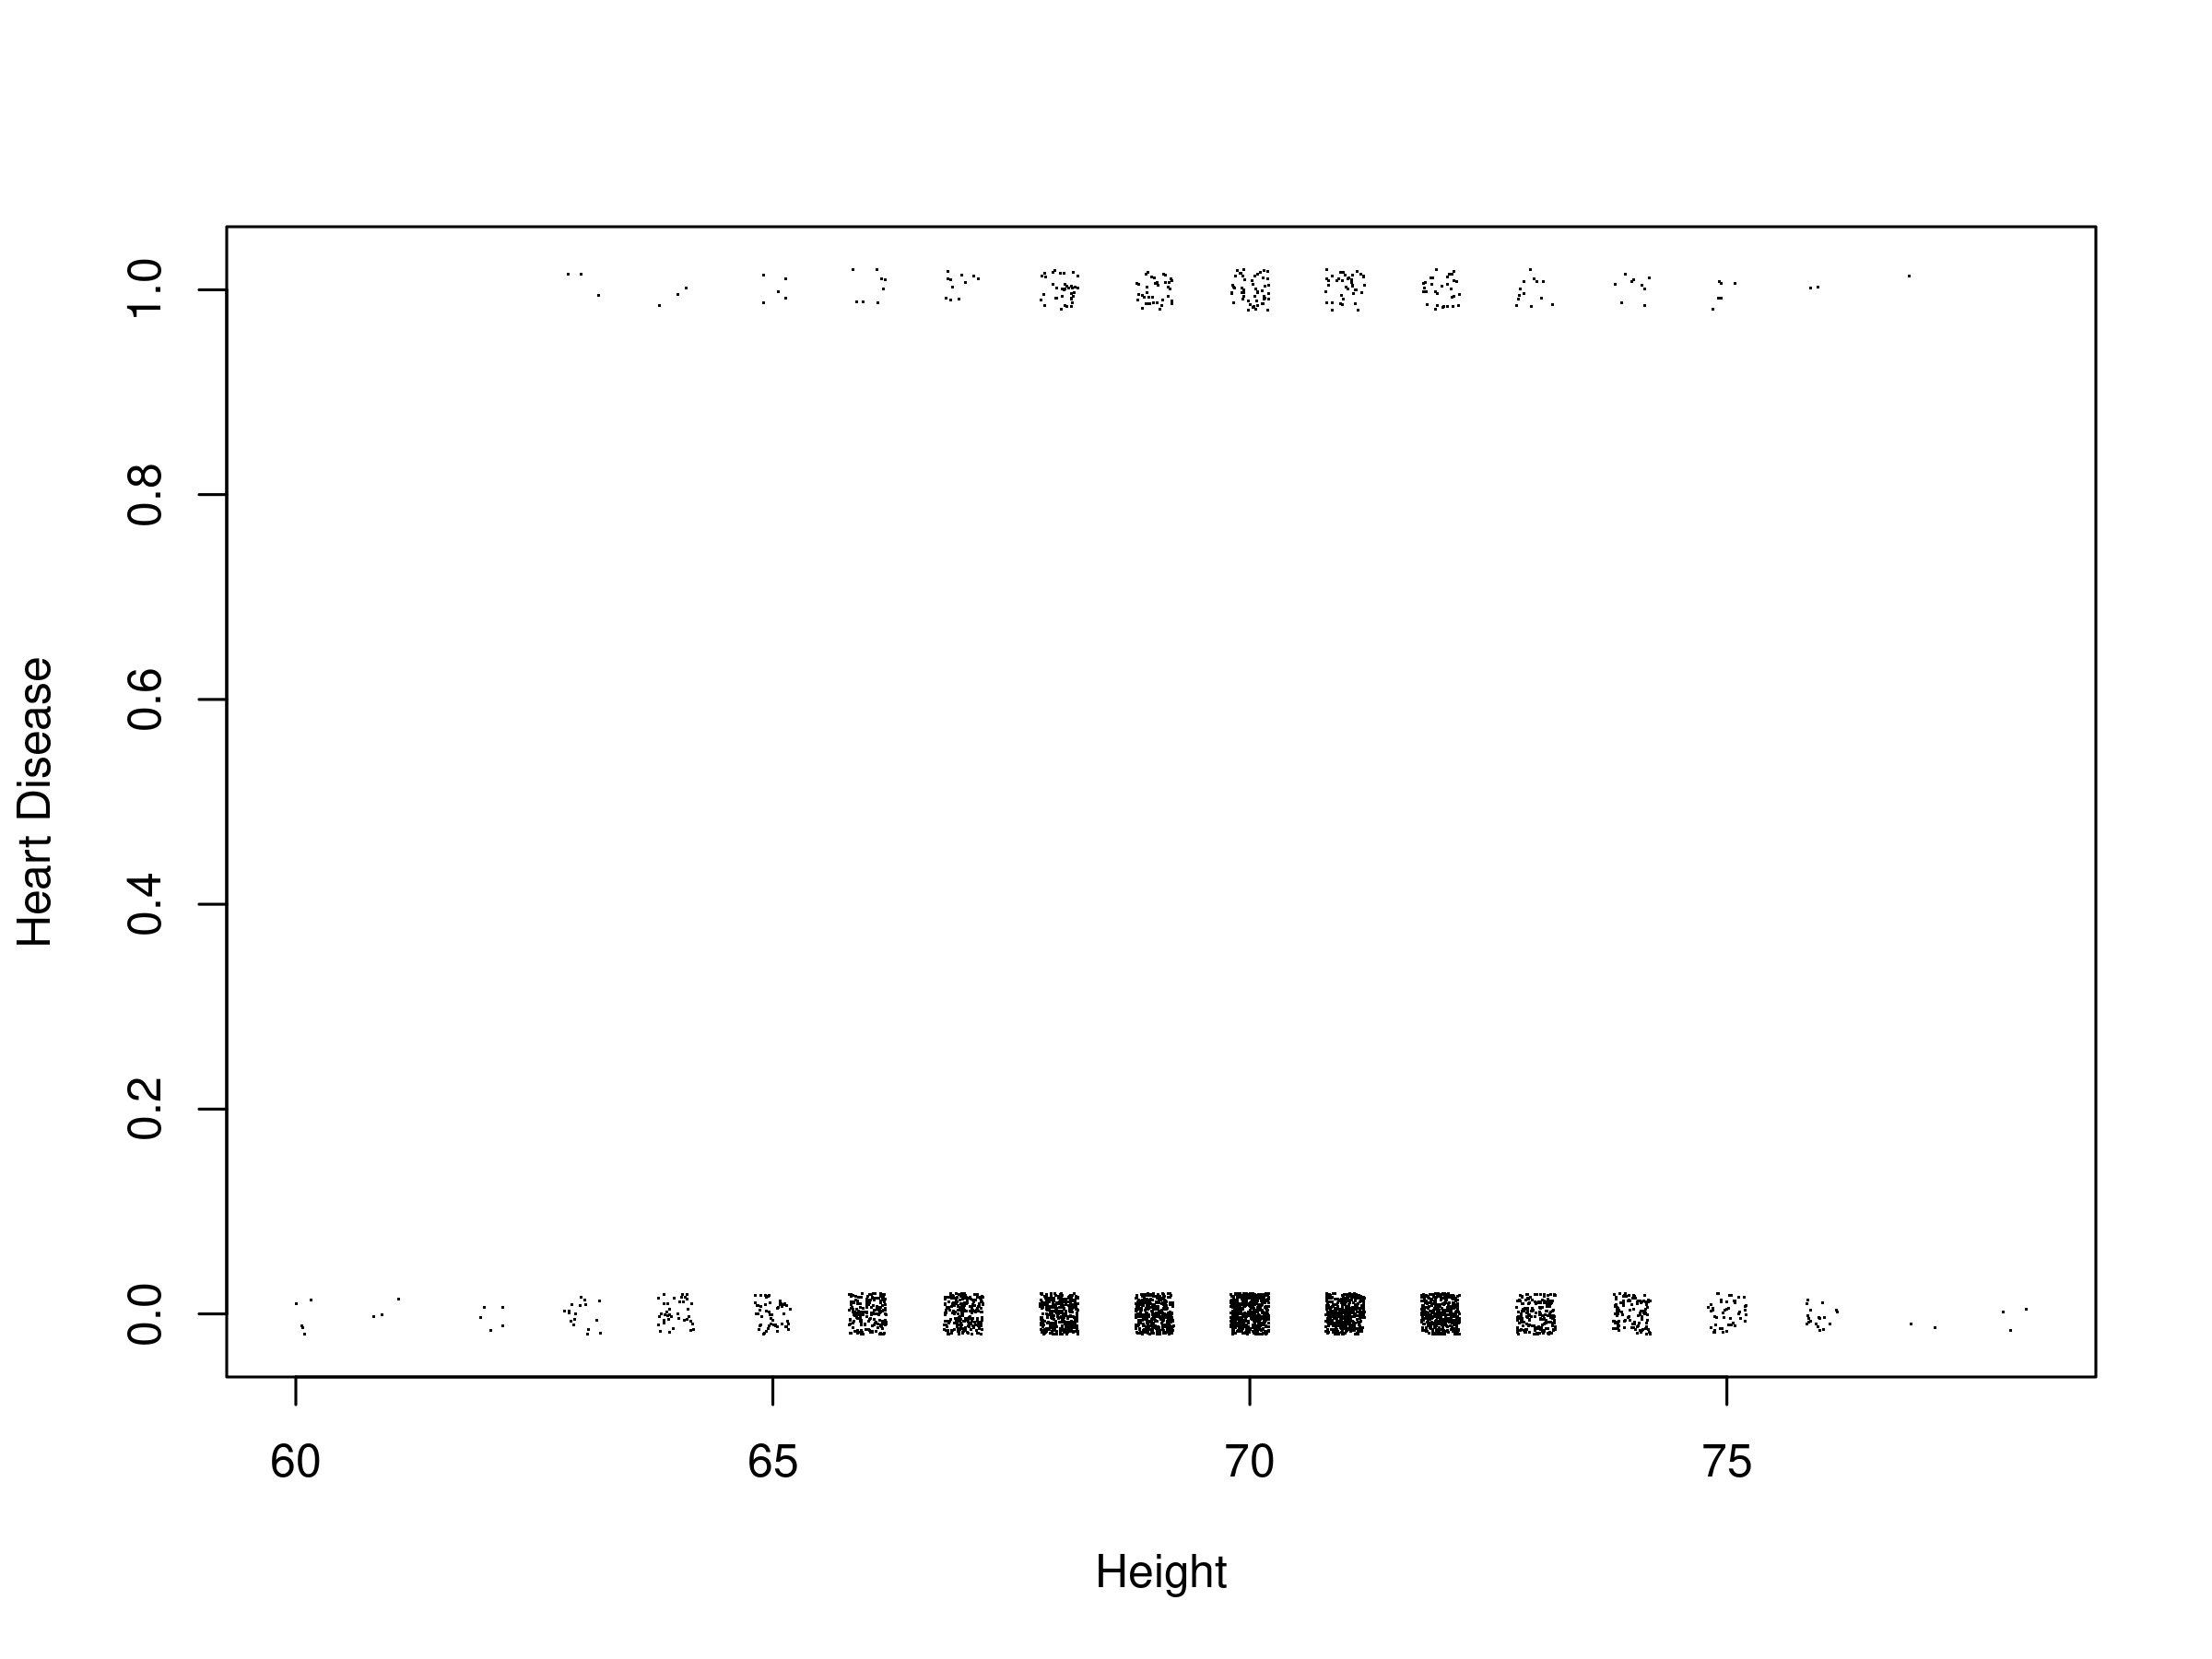

In [4]:
wcgs$y <- ifelse(wcgs$chd == "no",0,1)
plot(jitter(y,0.1) ~ jitter(height), wcgs, xlab="Height",  ylab="Heart Disease", pch=".")

library(ggplot2)

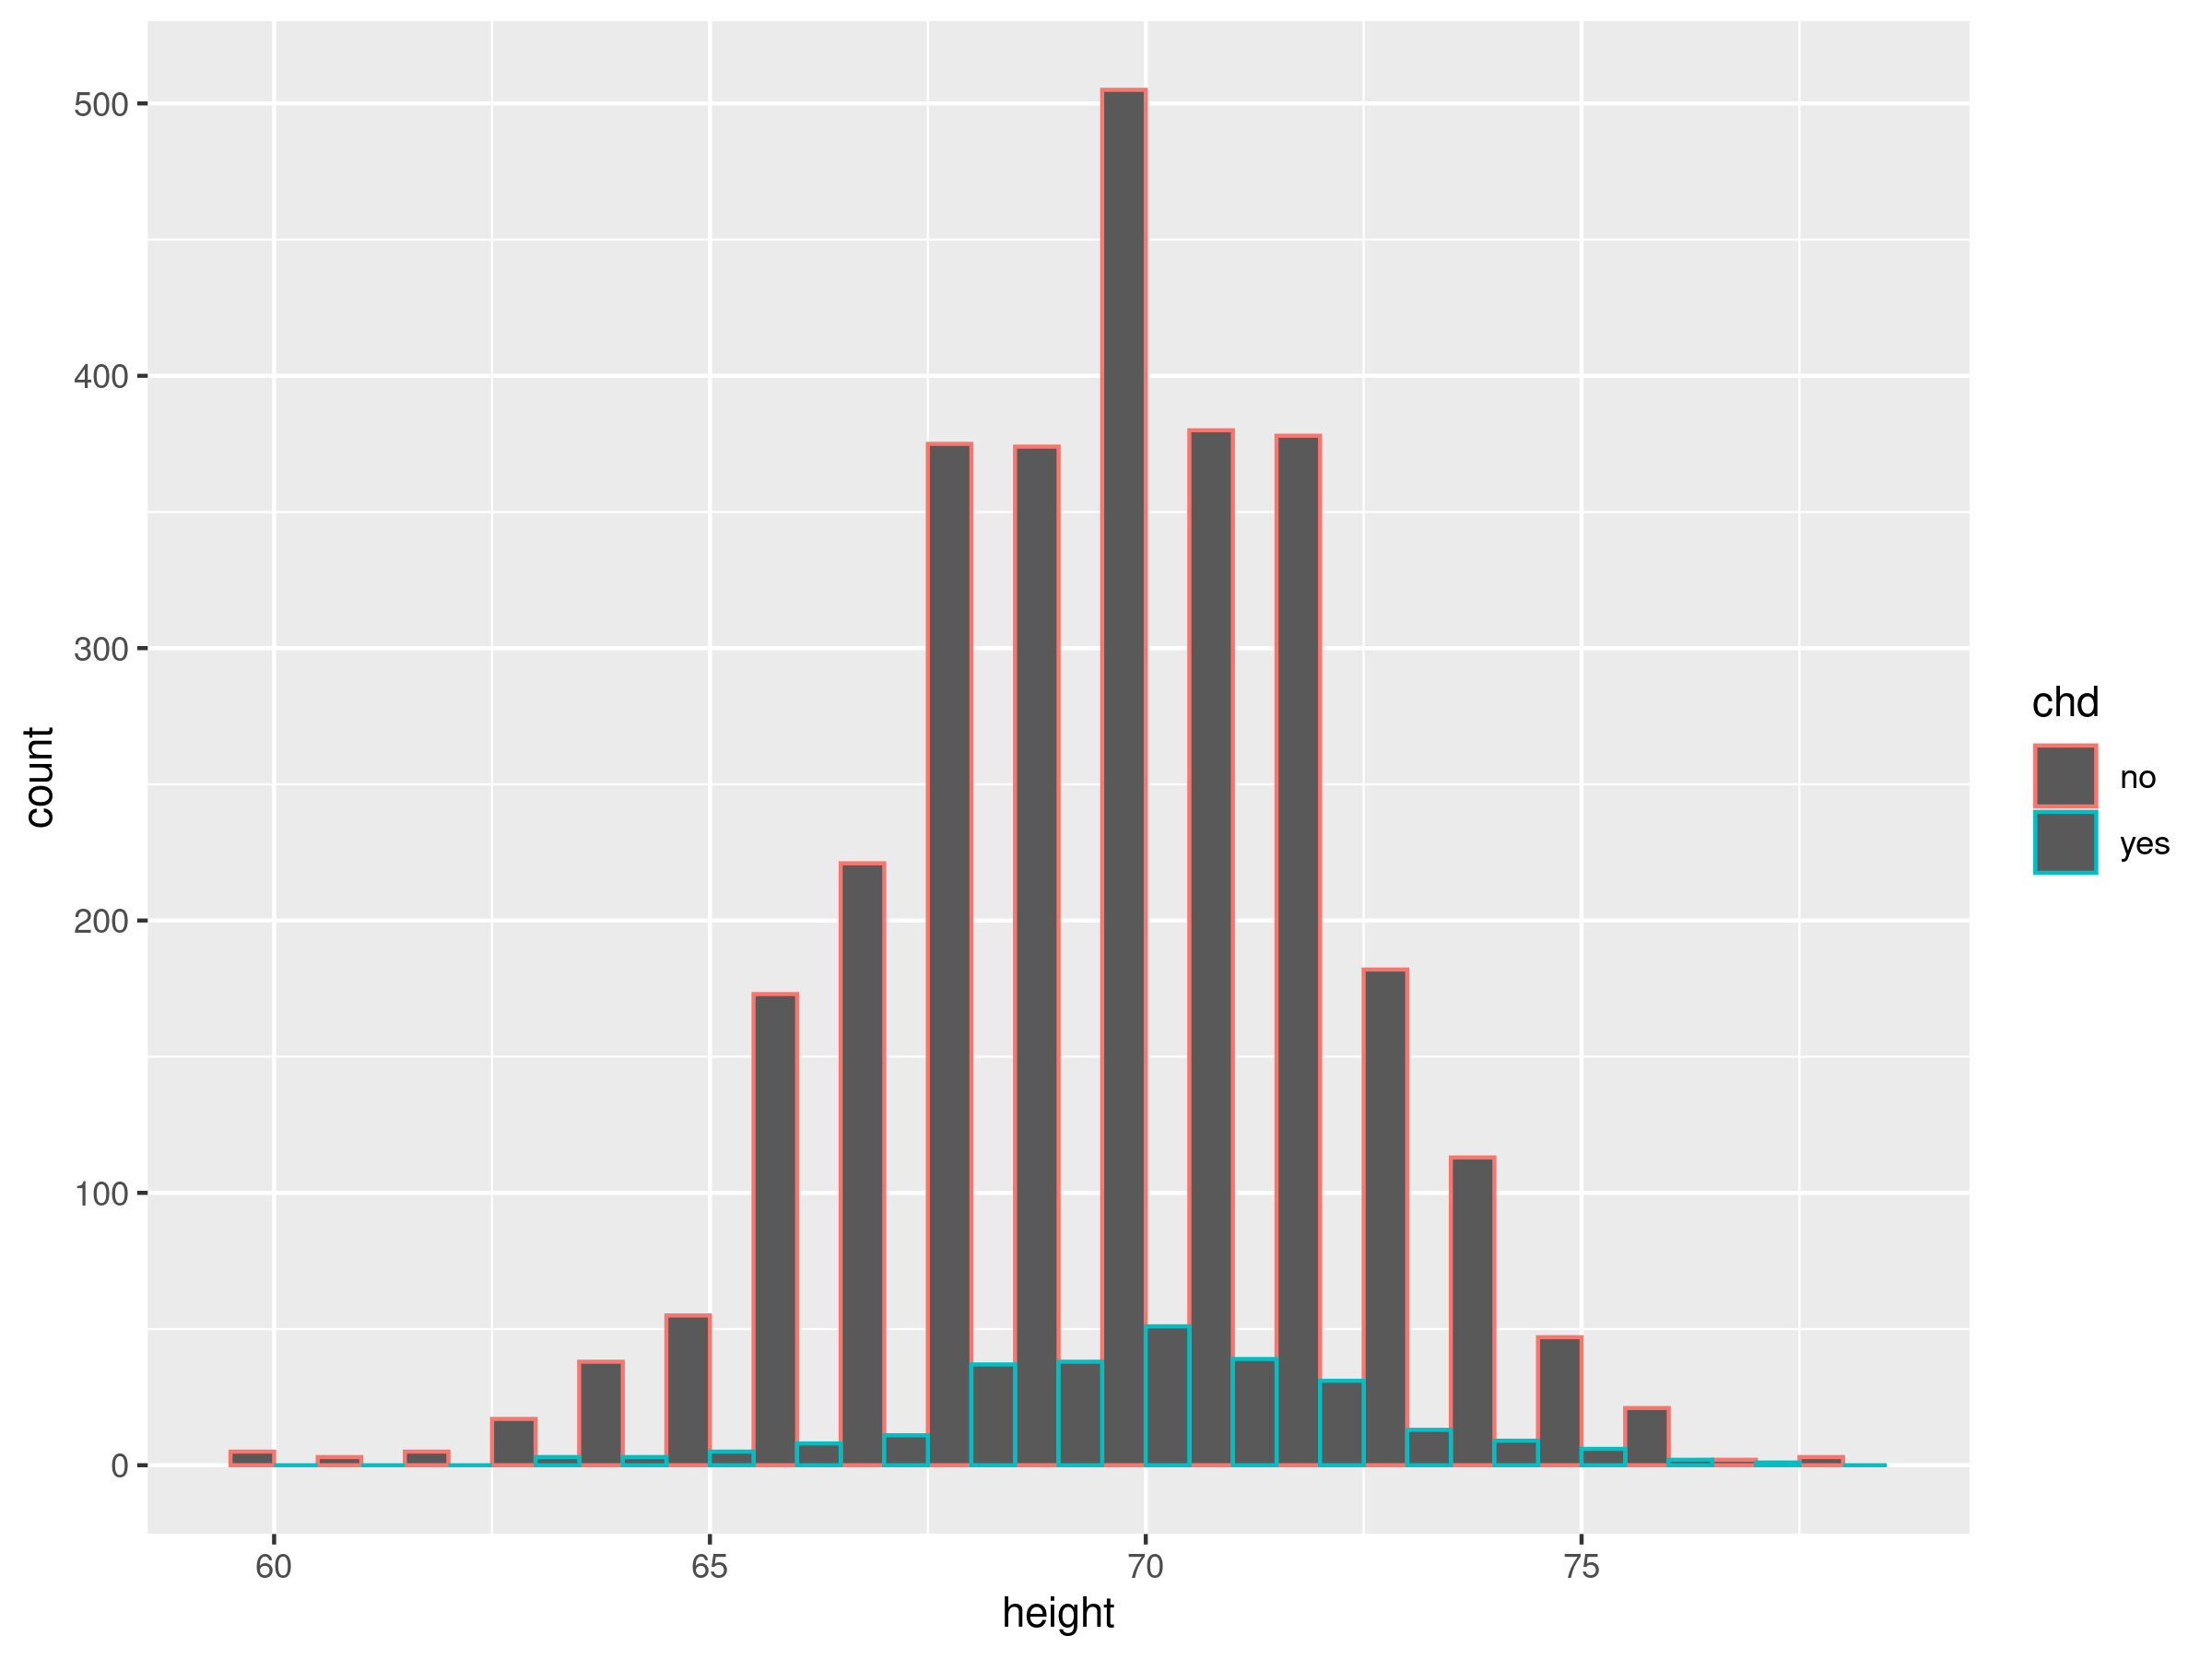

In [5]:
ggplot(wcgs, aes(x=height, color=chd)) + geom_histogram(position="dodge", binwidth=1)

- no가 뚜렷하게 많이 분포해있는 모습

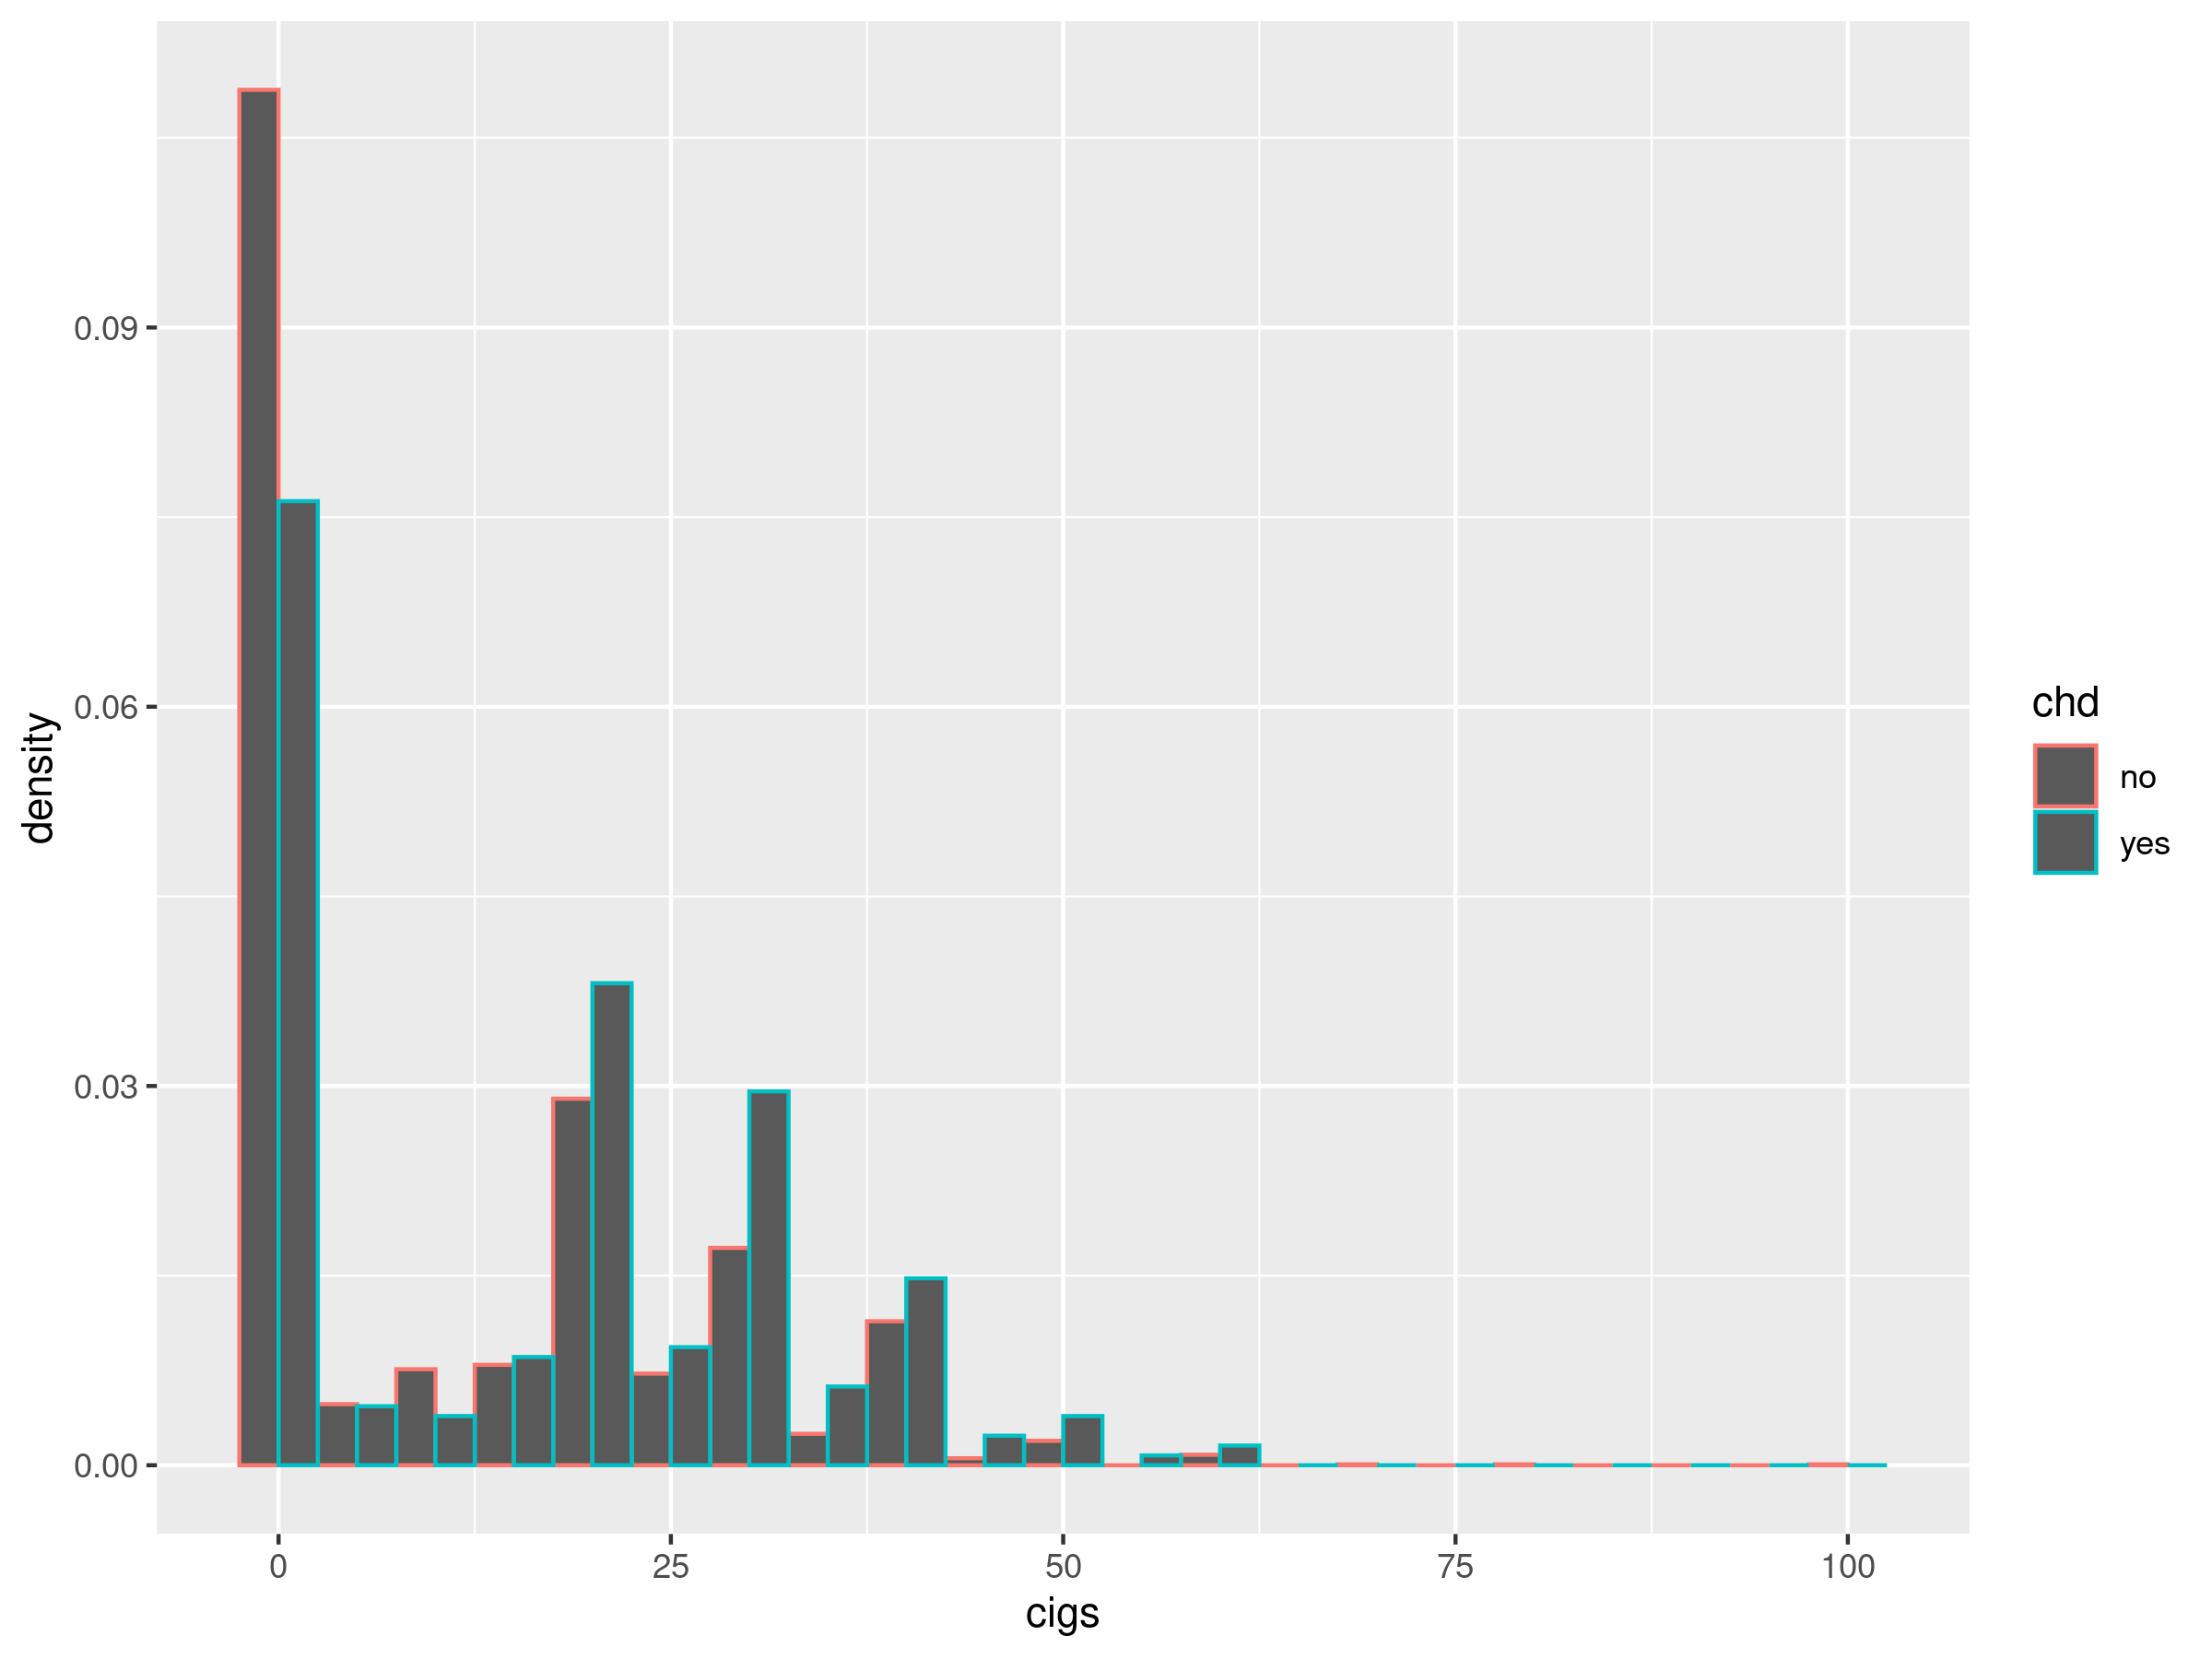

In [6]:
ggplot(wcgs, aes(x=cigs, color=chd)) + geom_histogram(position="dodge", binwidth=5, aes(y=..density..))

- yes가 높은 경향

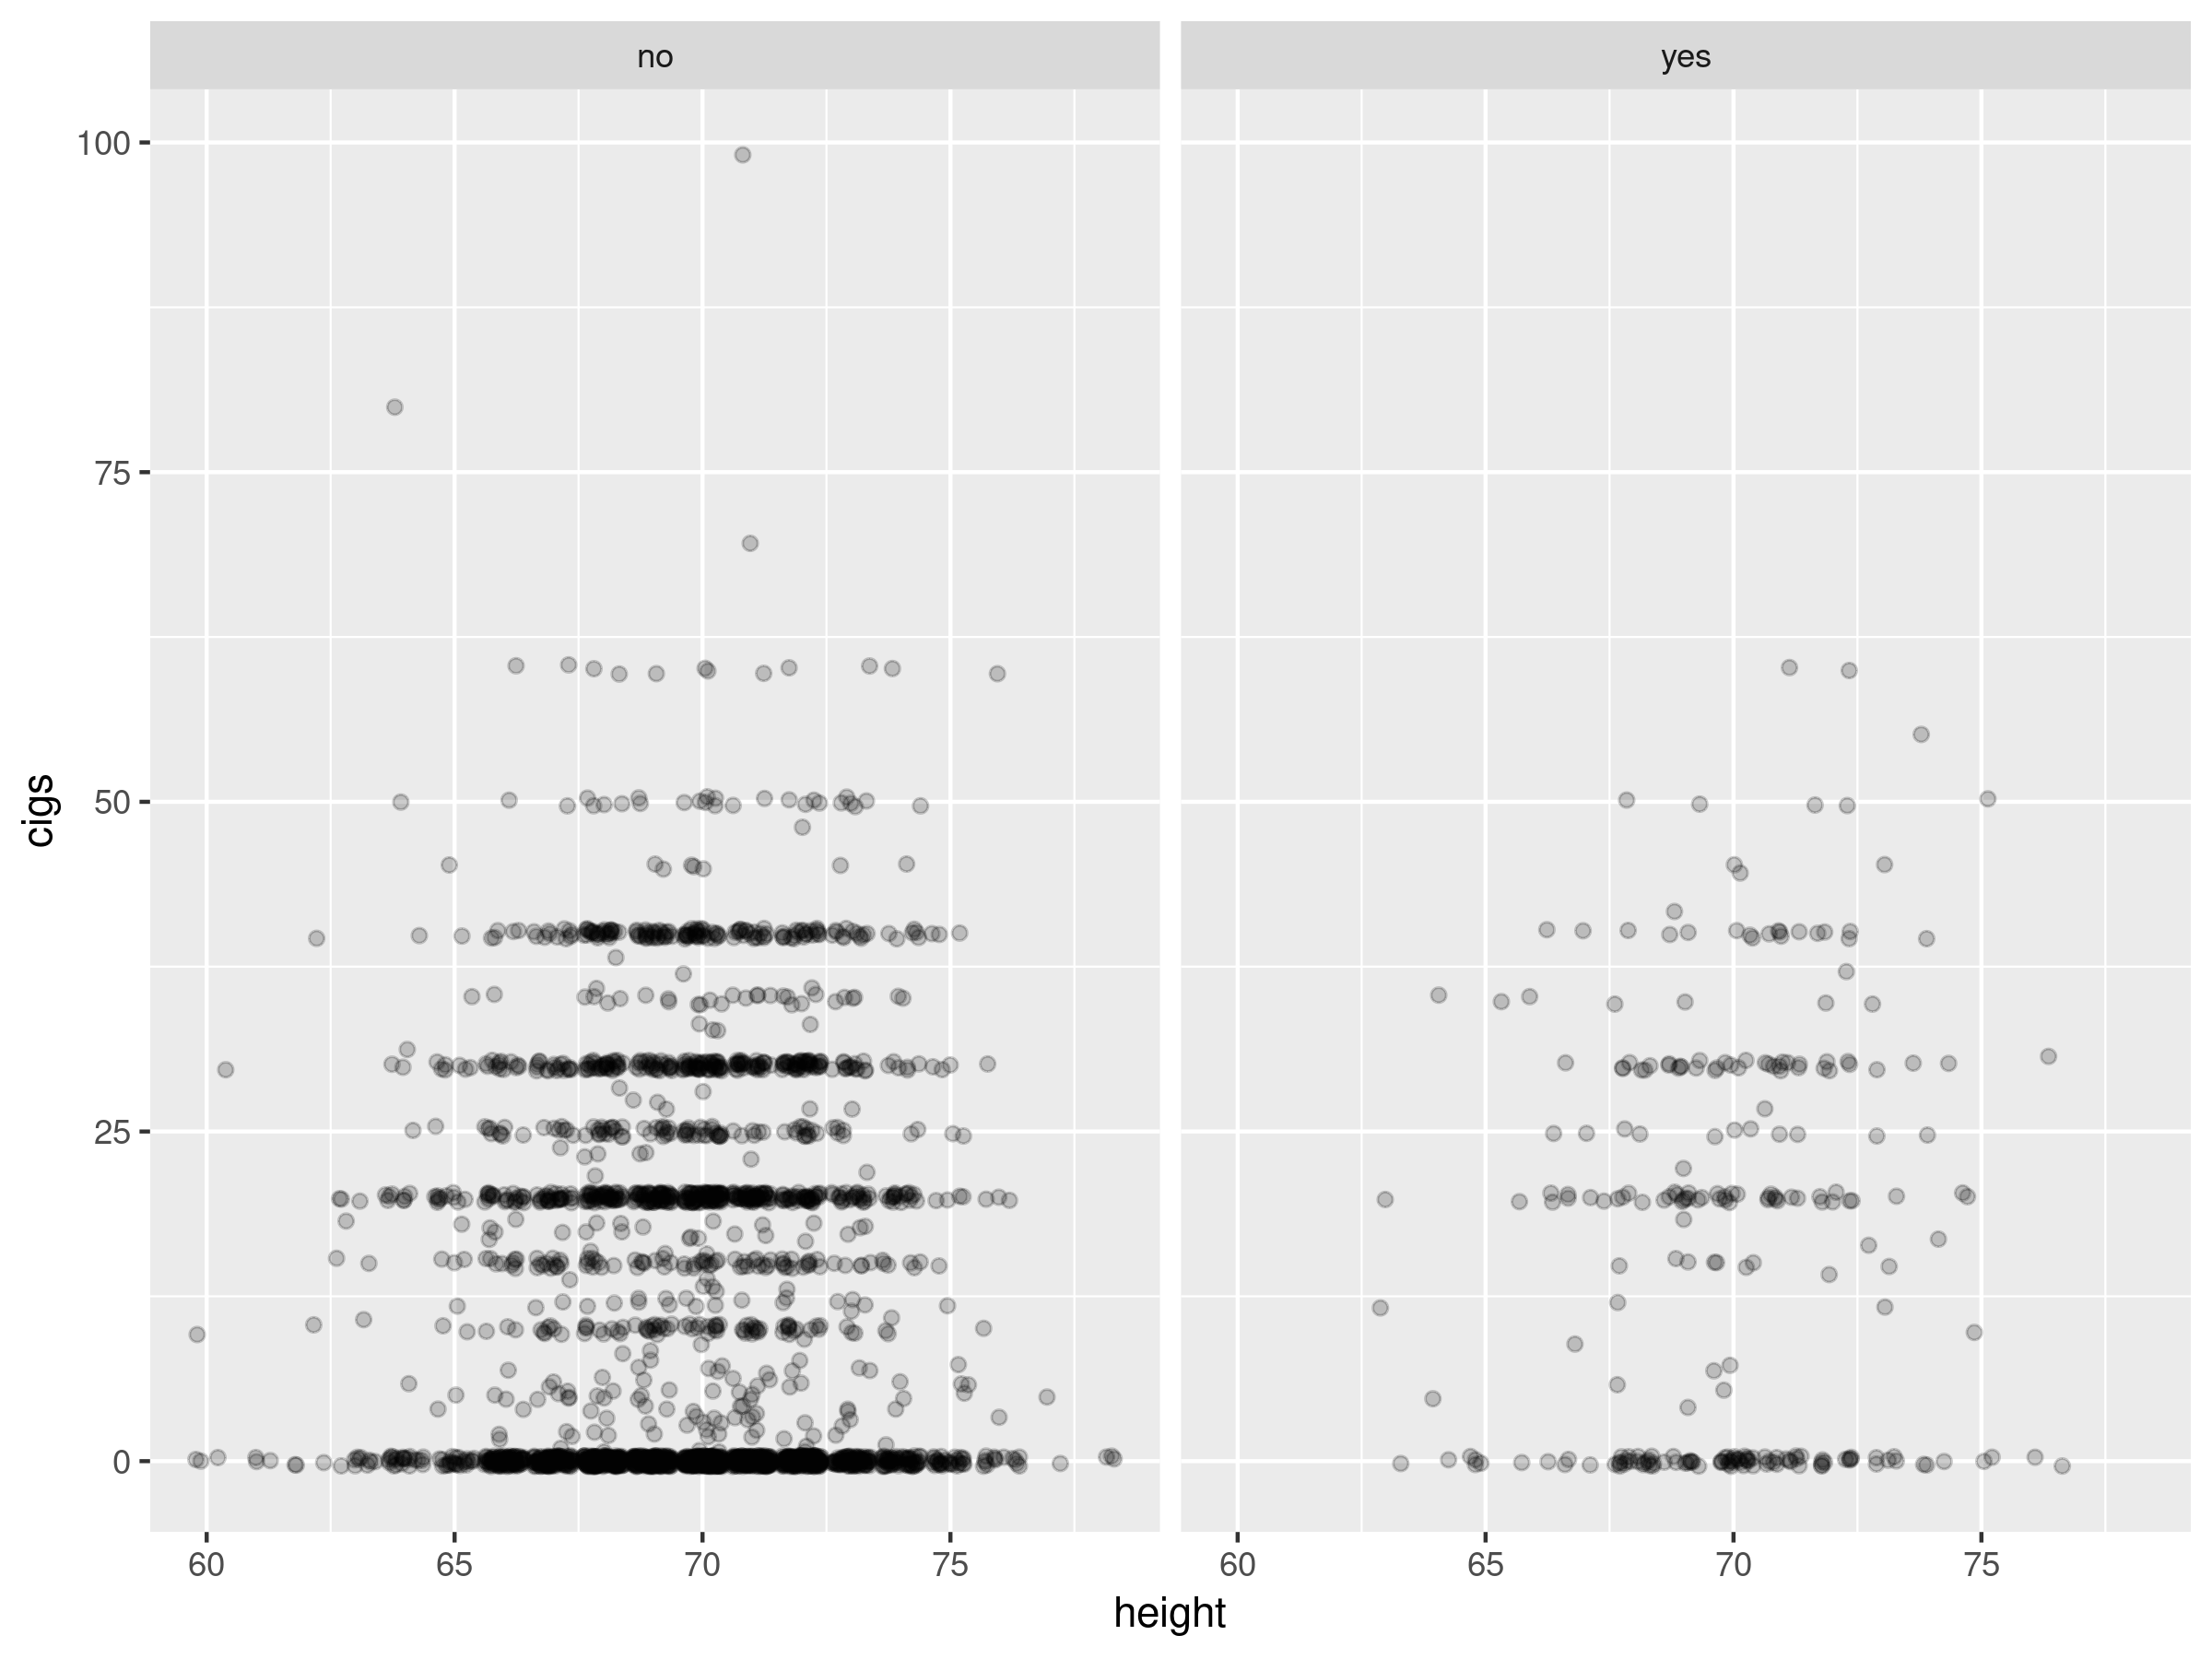

In [7]:
ggplot(wcgs, aes(x=height,y=cigs))+geom_point(alpha=0.2, position=position_jitter())+facet_grid(~ chd)

키 혹은 흡연량이 질환여부와 연관이 있어 보이는가? 만약 그렇다면 어떻게 모형화 할 수 있겠는가?

 ### 1.2 Conditional mean regression

선형모형은 반응변수 $Y$를 설명변수 $x_1,…,x_p$의 선형겹합 $+ noise$ 로 표현한 것이다. 사실 `선형`이라는 의미는 오차항을 제외한 부분을 선형으로 모형화한다는 의미로 볼 수 있다.
- 설명변수를 linear로 모델링

$$E(Y|x_1,…,x_p)=β_0+β_1x_1+…+β_px_p$$
- $Y = f(X_1, \dots, X_p) + \epsilon$
- $E(\epsilon|x_1,\dots,x_p) = 0$
- $Y = 0 or 1$
- $E(Y) = p \times 1 + (1-p) \times 0 = p = P_r(Y=1)$

즉, 선형모형은 설명변수가 주어졌을 때 반응변수의 조건부 기대값(평균)을 설병변수들의 선형결합으로 모형화하고 있는 것이다. 반응변수 $Y$가 $Binary$인 경우 조건부 기대값은 조건부 확률과 같으므로,

$$E(Y|x_1,…,x_p)=P(Y=1|x_1,…,x_p)=β_0+β_1x_1+…+β_px_p$$
- R(실수 전체 가능)

과 같은 모형화가 가능하다.

하지만 위와 같은 모형은 모수추정에 따라 주어지는 조건부 확률의 추정치가 $proper range( [0,1] )$를 보장해주지 못한다. 이는 자료의 범위를 벗어나는 부분에서 특히 발생할 수 있는 문제이다.
- 음수예측이나 드문드문 있는 데이터로 불안정한 예측

이를 해결할 수 있는 간단한 해결책 중 하나는 $proper range$를 보장 할 수 있는 변환함수 $g$를 고려하는 것이다.

$$g(P(Y=1|x_1,…,x_p))=β_0+β_1x_1+…+β_px_p$$
- GLM
- $X^{\top} \beta$

반응변수가 $Binary$인 경우 이런 변환 함수는 다음과 같은 정의역과 공역을 가지는 것으로 선택한다.

$$g:(0,1)→R$$

변환함수는 다양하게 선택될 수 있으며, 반응변수의 특성에 따라 다른 변환함수를 고려하는 것이 자연스러울 것이다.

### 1.3 로지스틱 회귀 : Logistic regression

로지스틱 회귀모형은 $Binary response$인 경우 가장 흔하게 사용되는 모형이다.

$Y_i∈ \{ 0 ,1 \} , i=1,…,n$이고 $P(Y_i=1)=p_i∈(0,1)$이라 하자. 그리고 다음과 같은 모형을 생각하자.

$$η_i=g(p_i)=β_0+β_1x_{i1}+⋯+β_qx_{qi}$$
 = $X_i^{\top} \beta$

여기서 $η_i$를 $linear predictor$라 한다. 이 모형에서는 설명변수의 선형결합이 $g$를 통해서 $p_i$와 연결된다. 이 때 변환함수 $g$를 연결함수($link function$)이라 하고 이런 형태의 모형화를 통칭하여 일반화선형모형 `Generalized linear model (GLM)`이라 부른다. 사실 앞서 배운 전통적인 선형모형은 $g(x)=x$인 GLM의 특수한 형태로 볼 수 있다.

앞서 언급했듯이 $g$에 대한 선택은 정답이 있는 것은 아니나 계산상의 이유, 추정량의 성질과 관련된 이유, 모형의 해석과 관련된 이유, 데이터와의 적합성과 관련된 이유 등으로 주로 쓰여지는 함수들이 존재한다. $Binary response$의 경우 가장 일반적으로 쓰이는 연결함수는 $logit$ 연결함수이며 다음과 같이 정의된다.
- link function 사용하기 때문에 추정량 성질과 관련될 수 있지
- 어떤 연결함수를 사용하는지에 따라 모형이 달라진다.
- 더 좋은 적합도를 가진 link function을 찾아야 함.

$$g(t)=logit(t)=log\frac{t}{1−t}$$
- $h: R \to (0,1)$
- $lim_{t \to 0} g(t) = log 0 = - \infty$
- $lim_{t \to 1} g(t) = log \infty = \infty$

이 함수는 다음과 같이 정의되는 $logistic$ 함수의 역함수로 알려져 있다.

$$g^{−1}(t)=h(t)=\frac{1}{1+exp(−t)}=\frac{exp(t)}{1+exp(t)}$$

$logit$ 연결함수를 고려하는 $GLM$을 로지스틱 모형이라 부르고 다음과 같이 표현된다.

$$log\frac{p_i}{1−p_i}=β_0+β_1x_{i1}+⋯+β_qx_{qi}$$
- $p_i$ 자체의 움직임이 아니라 연결함수도 함께 고려해야한다. 달라질 수 있으니까
- $x$기 증가하면 $p$도 증가하고(positive), $x$가 감소하면 $p$도 감소할걸(negative)?

위에서 양변이 모두 $R$의 $range$를 가짐을 알 수 있다.

- $\hat{p}_i = P(Y_i=1|x_{i1}, \dots, x_{qi} ) = \frac{exp(\hat{η_i})}{1+exp(\hat{η_i})}$
- $1-\hat{p}_i = \frac{1}{1+exp(\hat{η_i})}$

In [8]:
library(faraway)


Attaching package: ‘faraway’


The following object is masked _by_ ‘.GlobalEnv’:

    wcgs




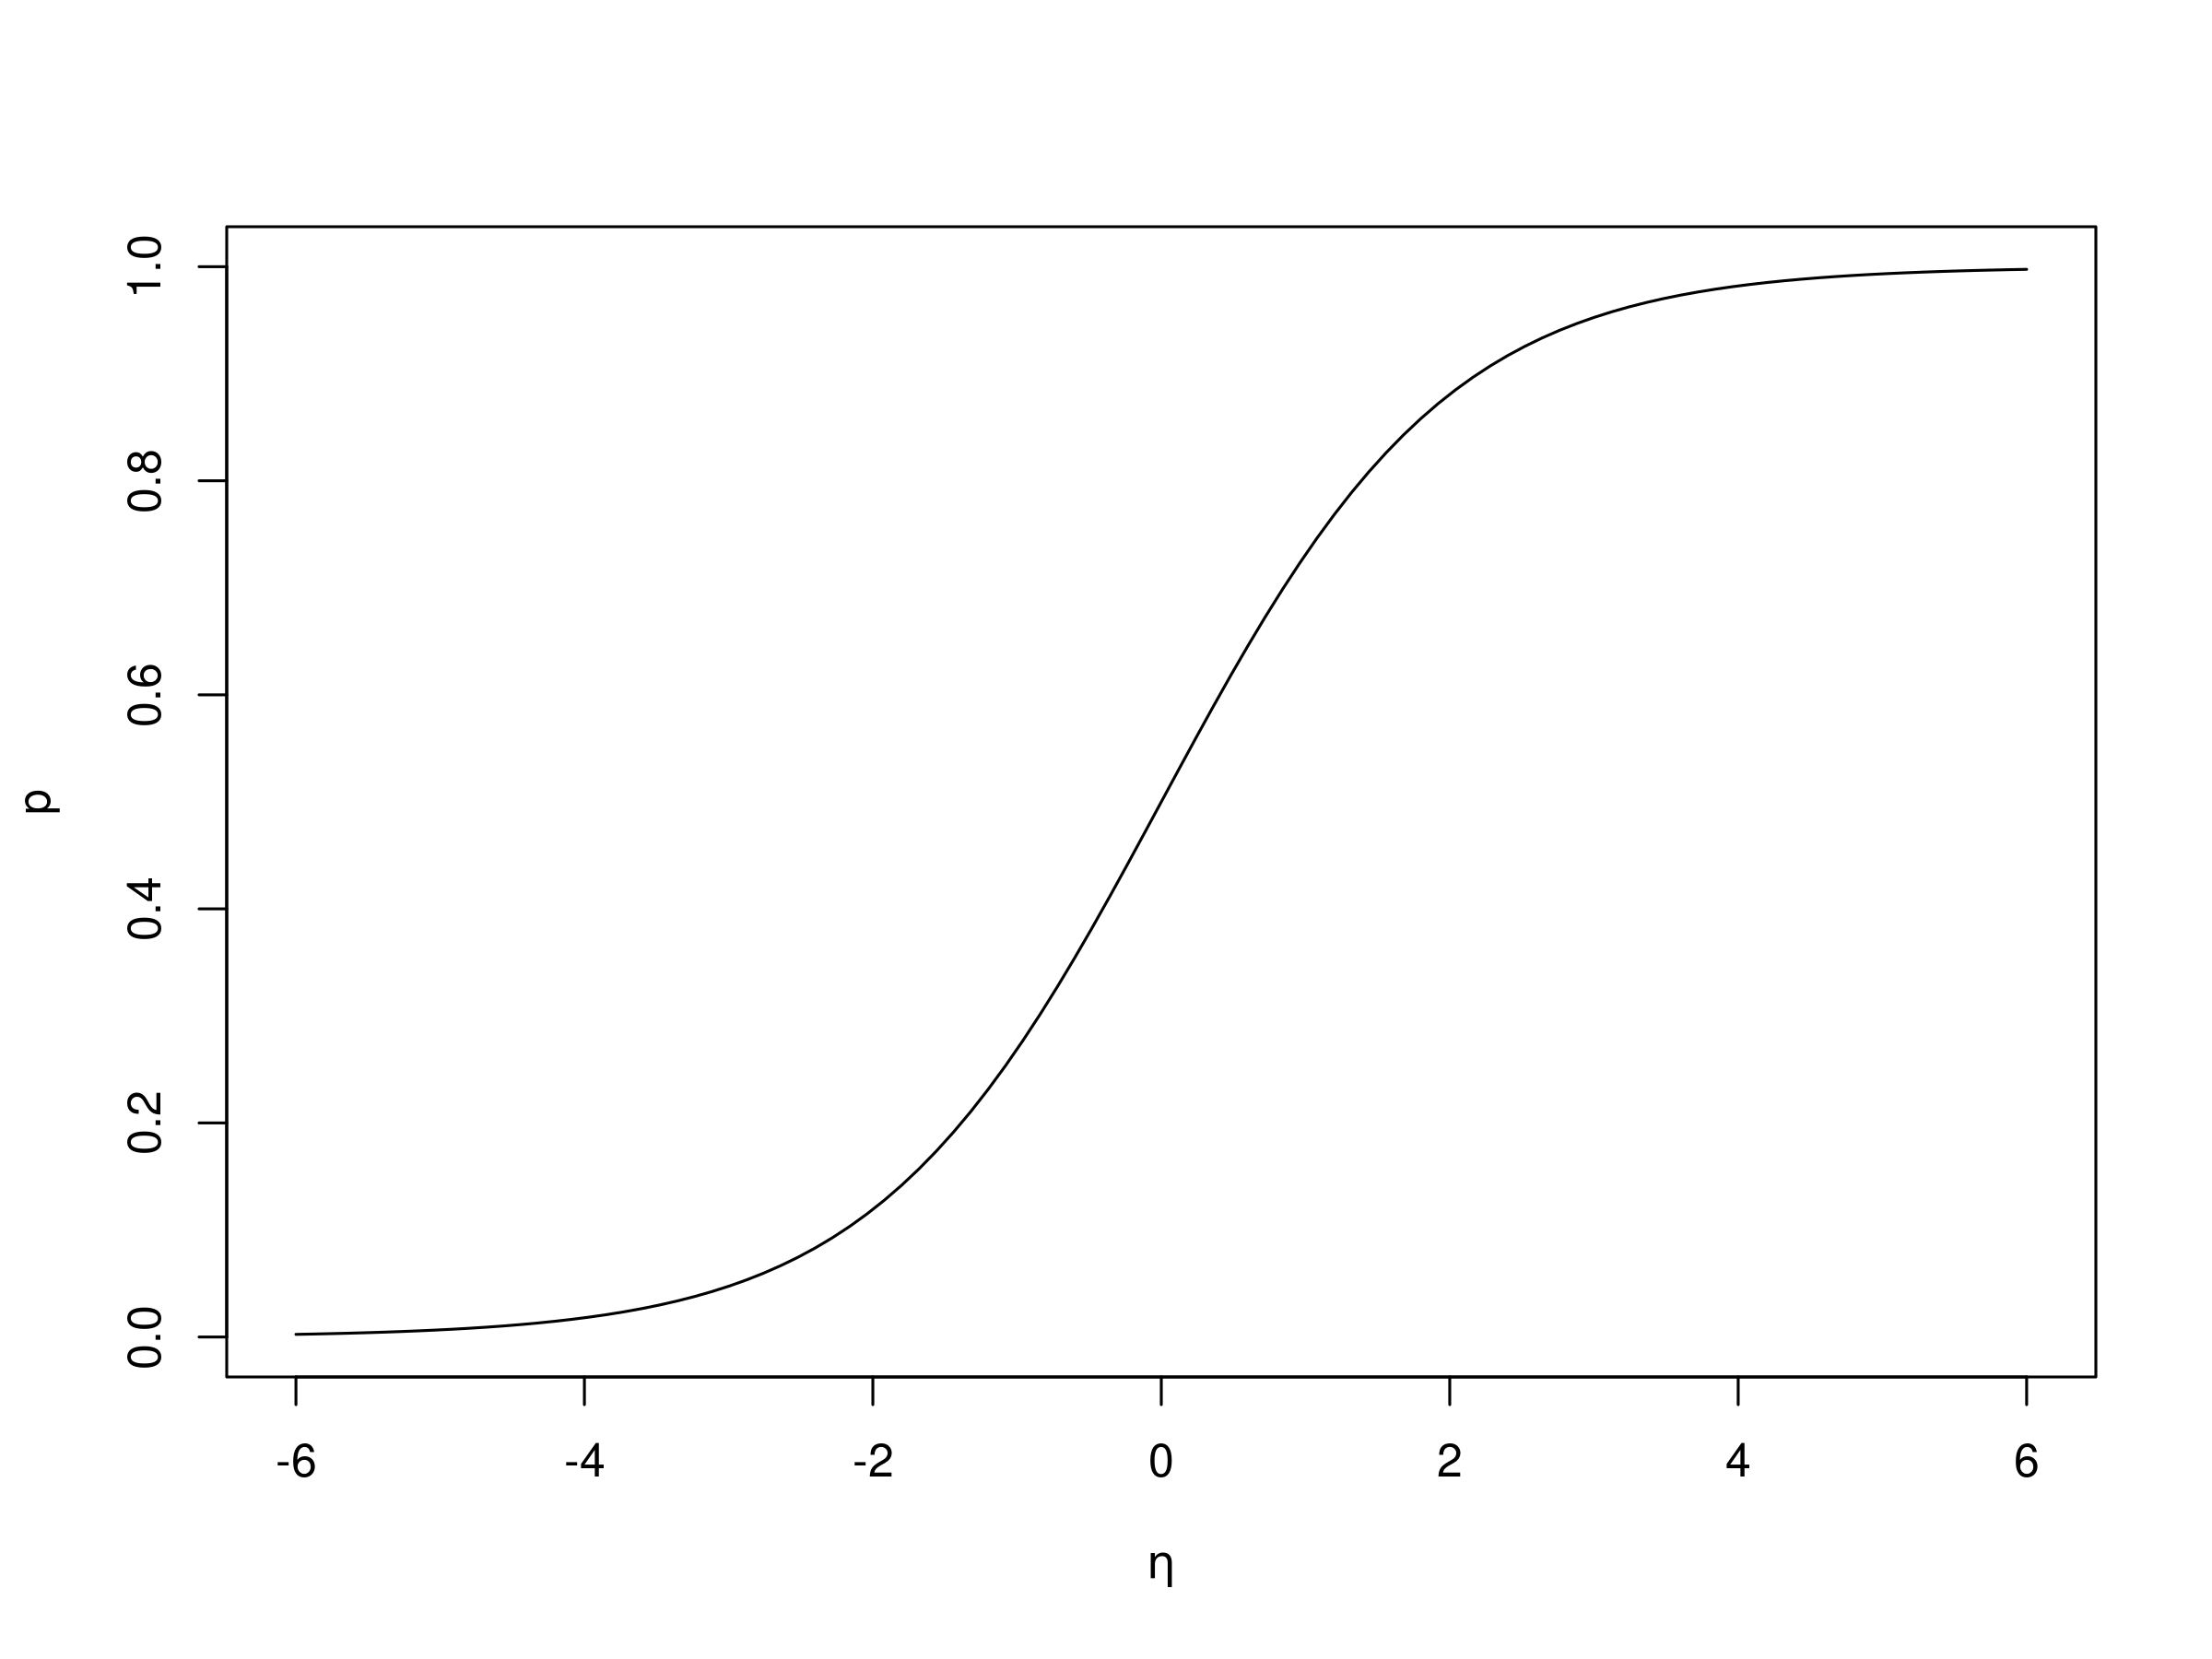

In [9]:
curve(ilogit(x),-6,6, xlab=expression(eta), ylab="p")

- linear로 하면 (0,1) 범위 벗어날 수 있다.

$logit$ 함수의 역함수 즉, $logistic$ 함수는 $S$자 형태의 곡선모양을 띠며 중심부분에서는 직선과 유사한 형태임을 알 수 있다.

모형이 정의되었으면 다음으로 모수의 추정량을 제시하여야 한다. 선형모형에서 사용하였던 최소제곱법의 원리를 차용할 수 있을까?

일반적으로 $GLM$에서는 최소제곱의 원리보다는 반응변수의 분포특성을 이용할 수 있는 최대가능도추정법을 사용한다.

$$l(β)=∑_{i=1}^{n}[y_iη_i−log(1+exp^{η_i})]$$
- $P(y_i = 1| x_{i1},\dots,x_{iq}) = p_i)$
- $y_{i|x_{i1},\dots,x_{iq}} \sim Bernoulli(p_i)$
- 확률질량함수$f(y_i) = p_i^{y_i}(1-p_i)^{1-y_i}, y_i = 0,1$
- $L = \Pi^{n}_{i=1} f(y_i) = \Pi^{n}_{i=1} p_{i}^{y_i}(1-p_i)^{1-y_i}$
- $l = \log L = \sum^{n}_{i=1} (y_i \log p_i + (1-y_i) \log(1-p_i))$
- $= \sum^{n}_{i=1}(y_i \log p_i - y_i \log (1-p_i) + \log (1-p_i))$
- $= \sum^{n}_{i=1} (y_i(log\frac{p_i}{1-p_i}) + \log (1-p_i))$
    - $\log \frac{p_i}{1-p_i} = \beta_0 + \beta_1 x_{i1} + \dots + \beta_q x_{qi} = η_i = X_{i}^{\top}\beta$
    - $\_i = \frac{exp(\hat{η_i})}{a+exp(\hat{η_i})}$
- $\sum^{n}_{i=1} [y_i η_i - \log (1+exp(\hat{η_i}))]$
- $argmax_{\beta = \beta_0,\dots, \beta_q} l(\beta) = MLE$

- $y_i = β_0+β_1x_{i1}+⋯+β_qx_{qi} + \epsilon$
- $argmin_{\beta_0,\dots,\beta_q}\sum(y_i - \hat{y})^2$
    - 최소제곱법 사용?
    - $y_i$는 0 또는 1의 값이 나오고
    - $\hat{y}$는 0에서 1사이의 값이 나온다.
    - 어떻게 계산해? $y_i$를 실수화시키자

위 로그가능도함수를 β에 대해서 최대화시키면 그 값이 추정량이 된다.

- 밑에서 family에 반응변수의 특성을 입력해주자
- continuous? binomial?

In [10]:
lmod <- glm(chd ~ height + cigs, family = binomial, wcgs)
summary(lmod)


Call:
glm(formula = chd ~ height + cigs, family = binomial, data = wcgs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0041  -0.4425  -0.3630  -0.3499   2.4357  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.50161    1.84186  -2.444   0.0145 *  
height       0.02521    0.02633   0.957   0.3383    
cigs         0.02313    0.00404   5.724 1.04e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1781.2  on 3153  degrees of freedom
Residual deviance: 1749.0  on 3151  degrees of freedom
AIC: 1755

Number of Fisher Scoring iterations: 5


- $g(\hat{p}_i) = log \frac{\hat{p}_i}{1-\hat{p}_i} = -4.50 + 0.025 h + 0.023 c$
- 키가 커지면, 담배를 많이 피면 질환 결릴 확률이 증가하는가?
    - 명확히 말하면 $log \frac{\hat{p}_i}{1-\hat{p}_i}$이 증가하지
- monotone increasing function

![](https://th.bing.com/th/id/OIP.3X_qmy8T6dbFWi8s1s6_aQAAAA?w=191&h=180&c=7&r=0&o=5&dpr=1.12&pid=1.7)

- 즉, h,c가 증가하면 $\hat{p}_i$가 증가한다고 해석가능, 즉 방향으로 해석가능

null deviance에서 residual deviance로 32.3 정도 감소했다.
- null deviance는 parameter 다 뺀 가장 작은 deviance라고 생각
- residual deviance = $D_M = -2(\log L_M - \log L_s)$
```r
    Null deviance: 1781.2  on 3153  degrees of freedom
Residual deviance: 1749.0  on 3151  degrees of freedom
```

In [11]:
(beta <- coef(lmod))

(Intercept)      height        cigs 
-4.50161397  0.02520779  0.02312740

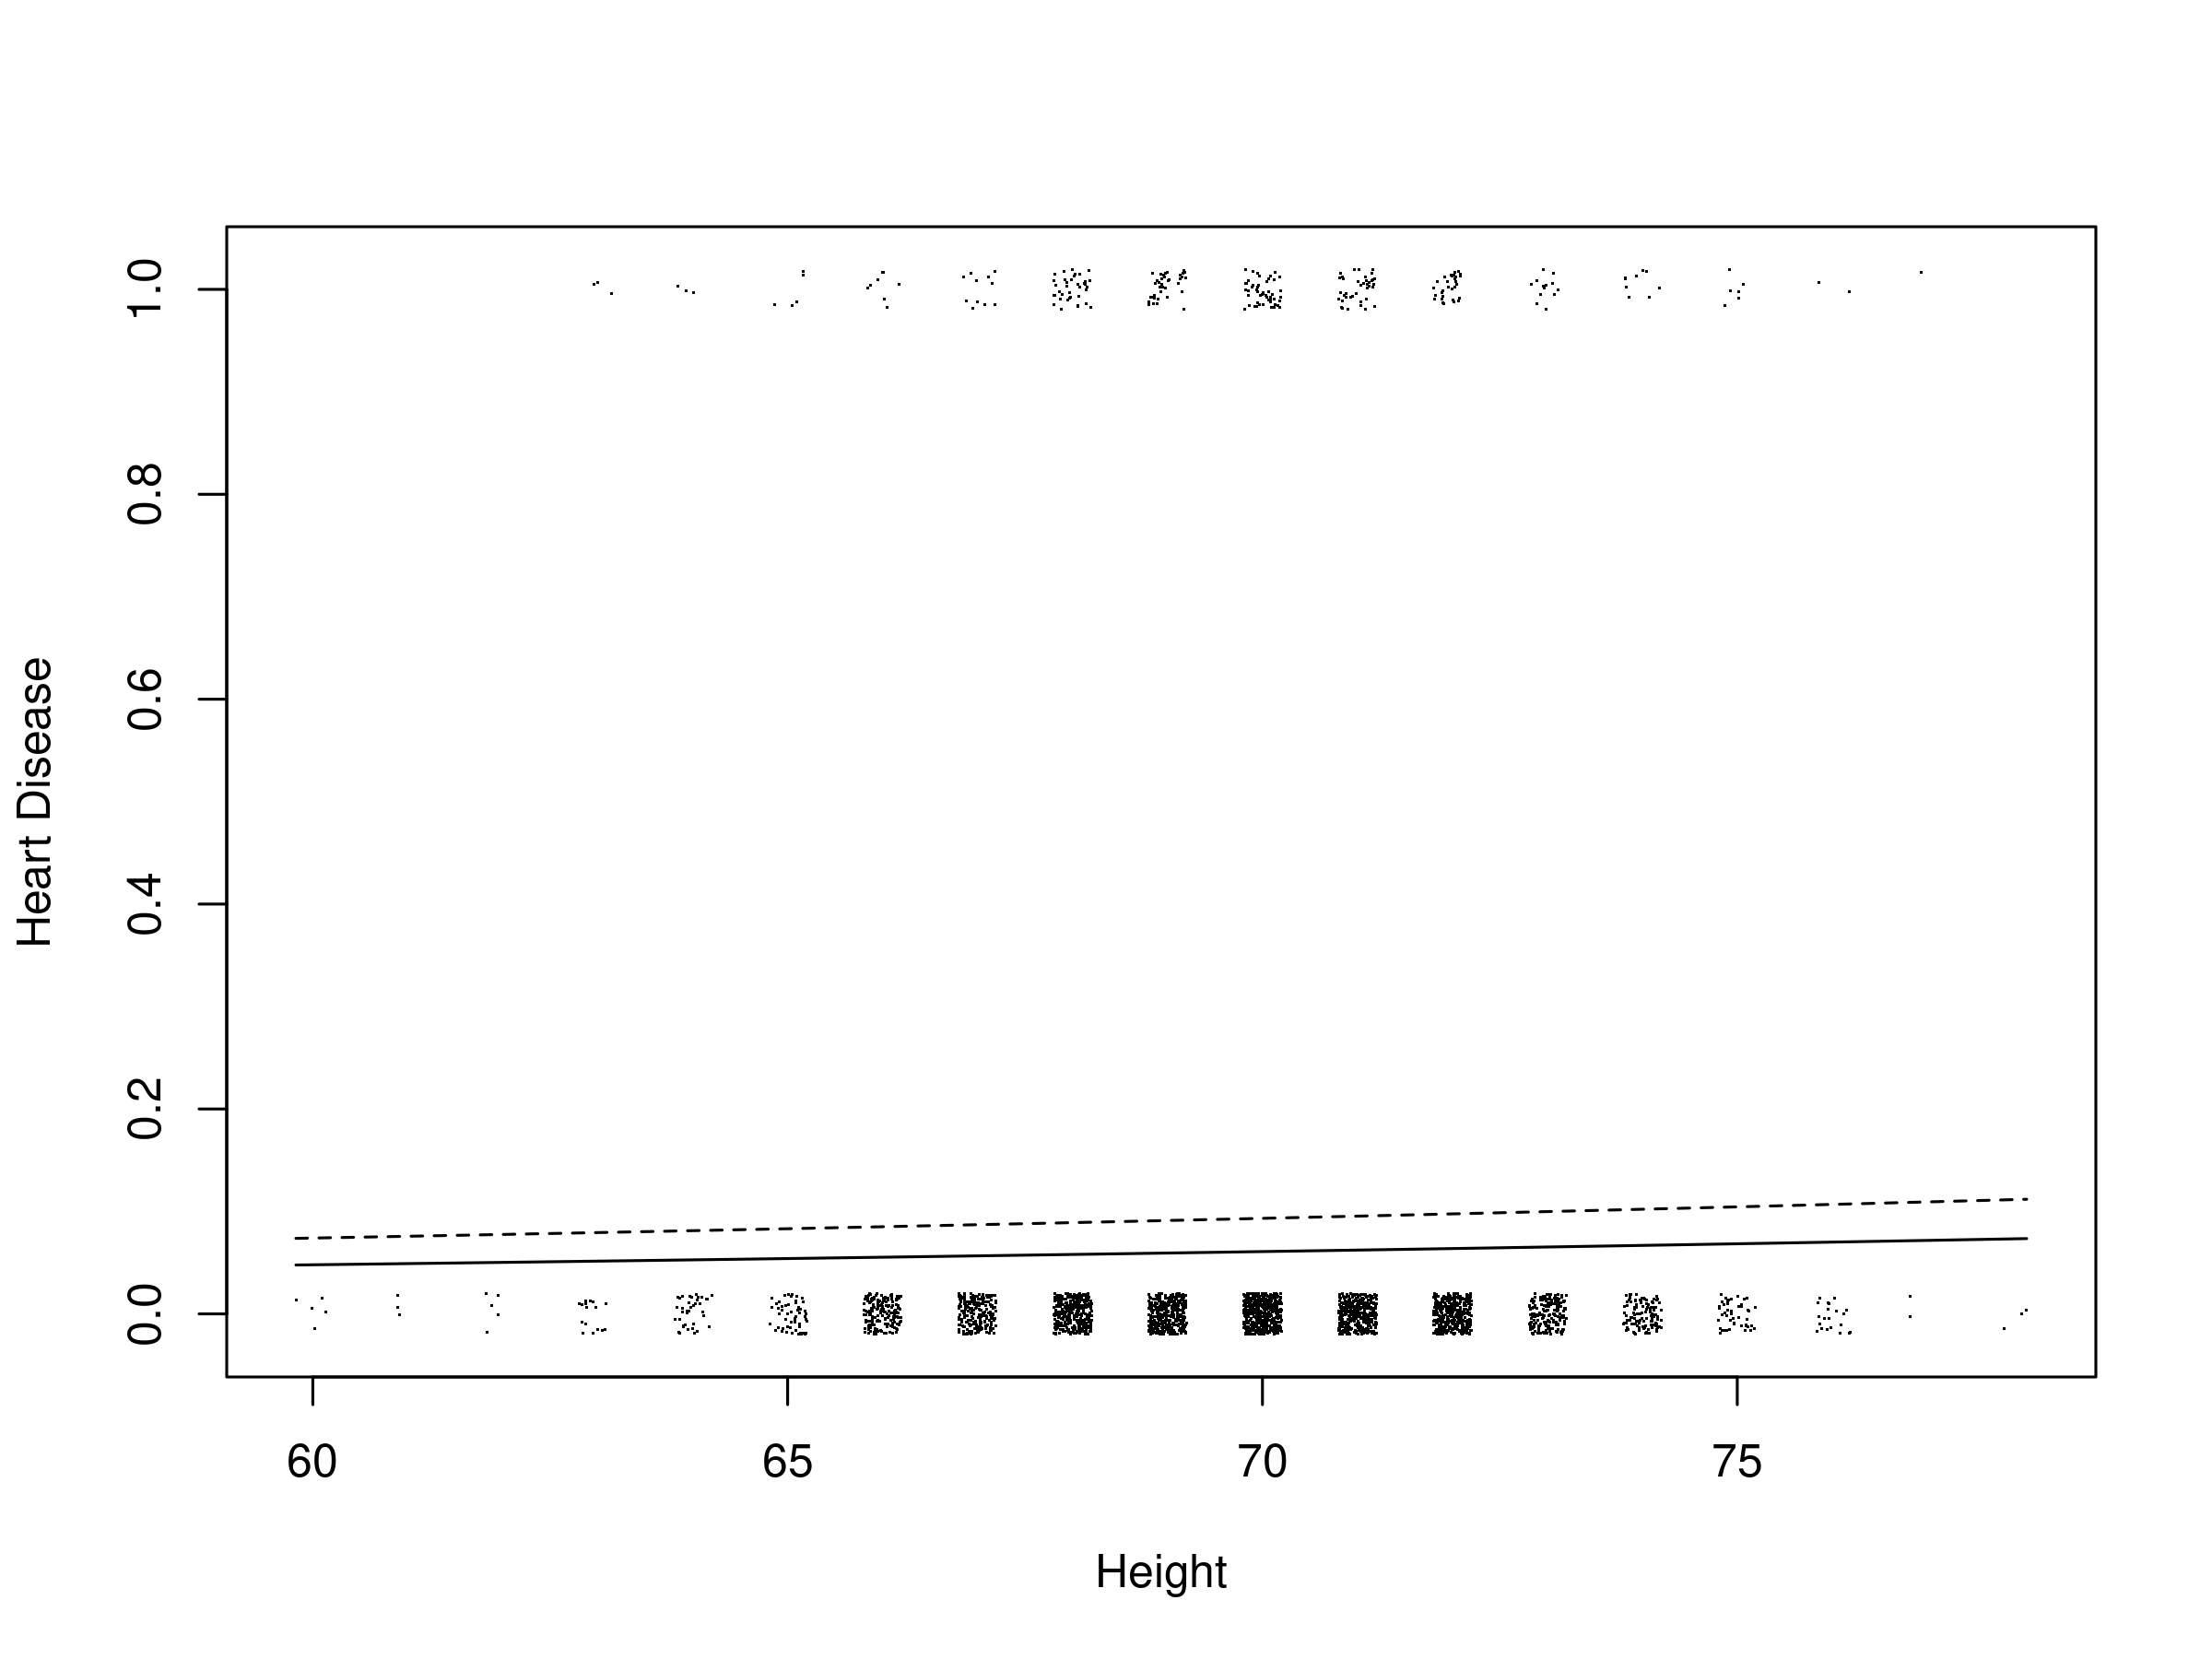

In [12]:
plot(jitter(y,0.1) ~ jitter(height), wcgs, xlab="Height", ylab="Heart Disease",pch=".")
curve(ilogit(beta[1] + beta[2]*x + beta[3]*0),add=TRUE)        # predicted curve with non-smokers
curve(ilogit(beta[1] + beta[2]*x + beta[3]*20),add=TRUE,lty=2) # predicted curve with smokers

- 흡연을 안하는 집단과
    - $\hat{\beta}_0 + \hat{\beta}_1 \times h + \hat{\beta}_2 \times 0$
- 흡연을 한 갑하는 집단
    - $\hat{\beta}_0 + \hat{\beta}_1 \times h + \hat{\beta}_2 \times 20$
- 흡연량에 따라 어떻게 변할까?
- $\hat{\beta})_1 >0$

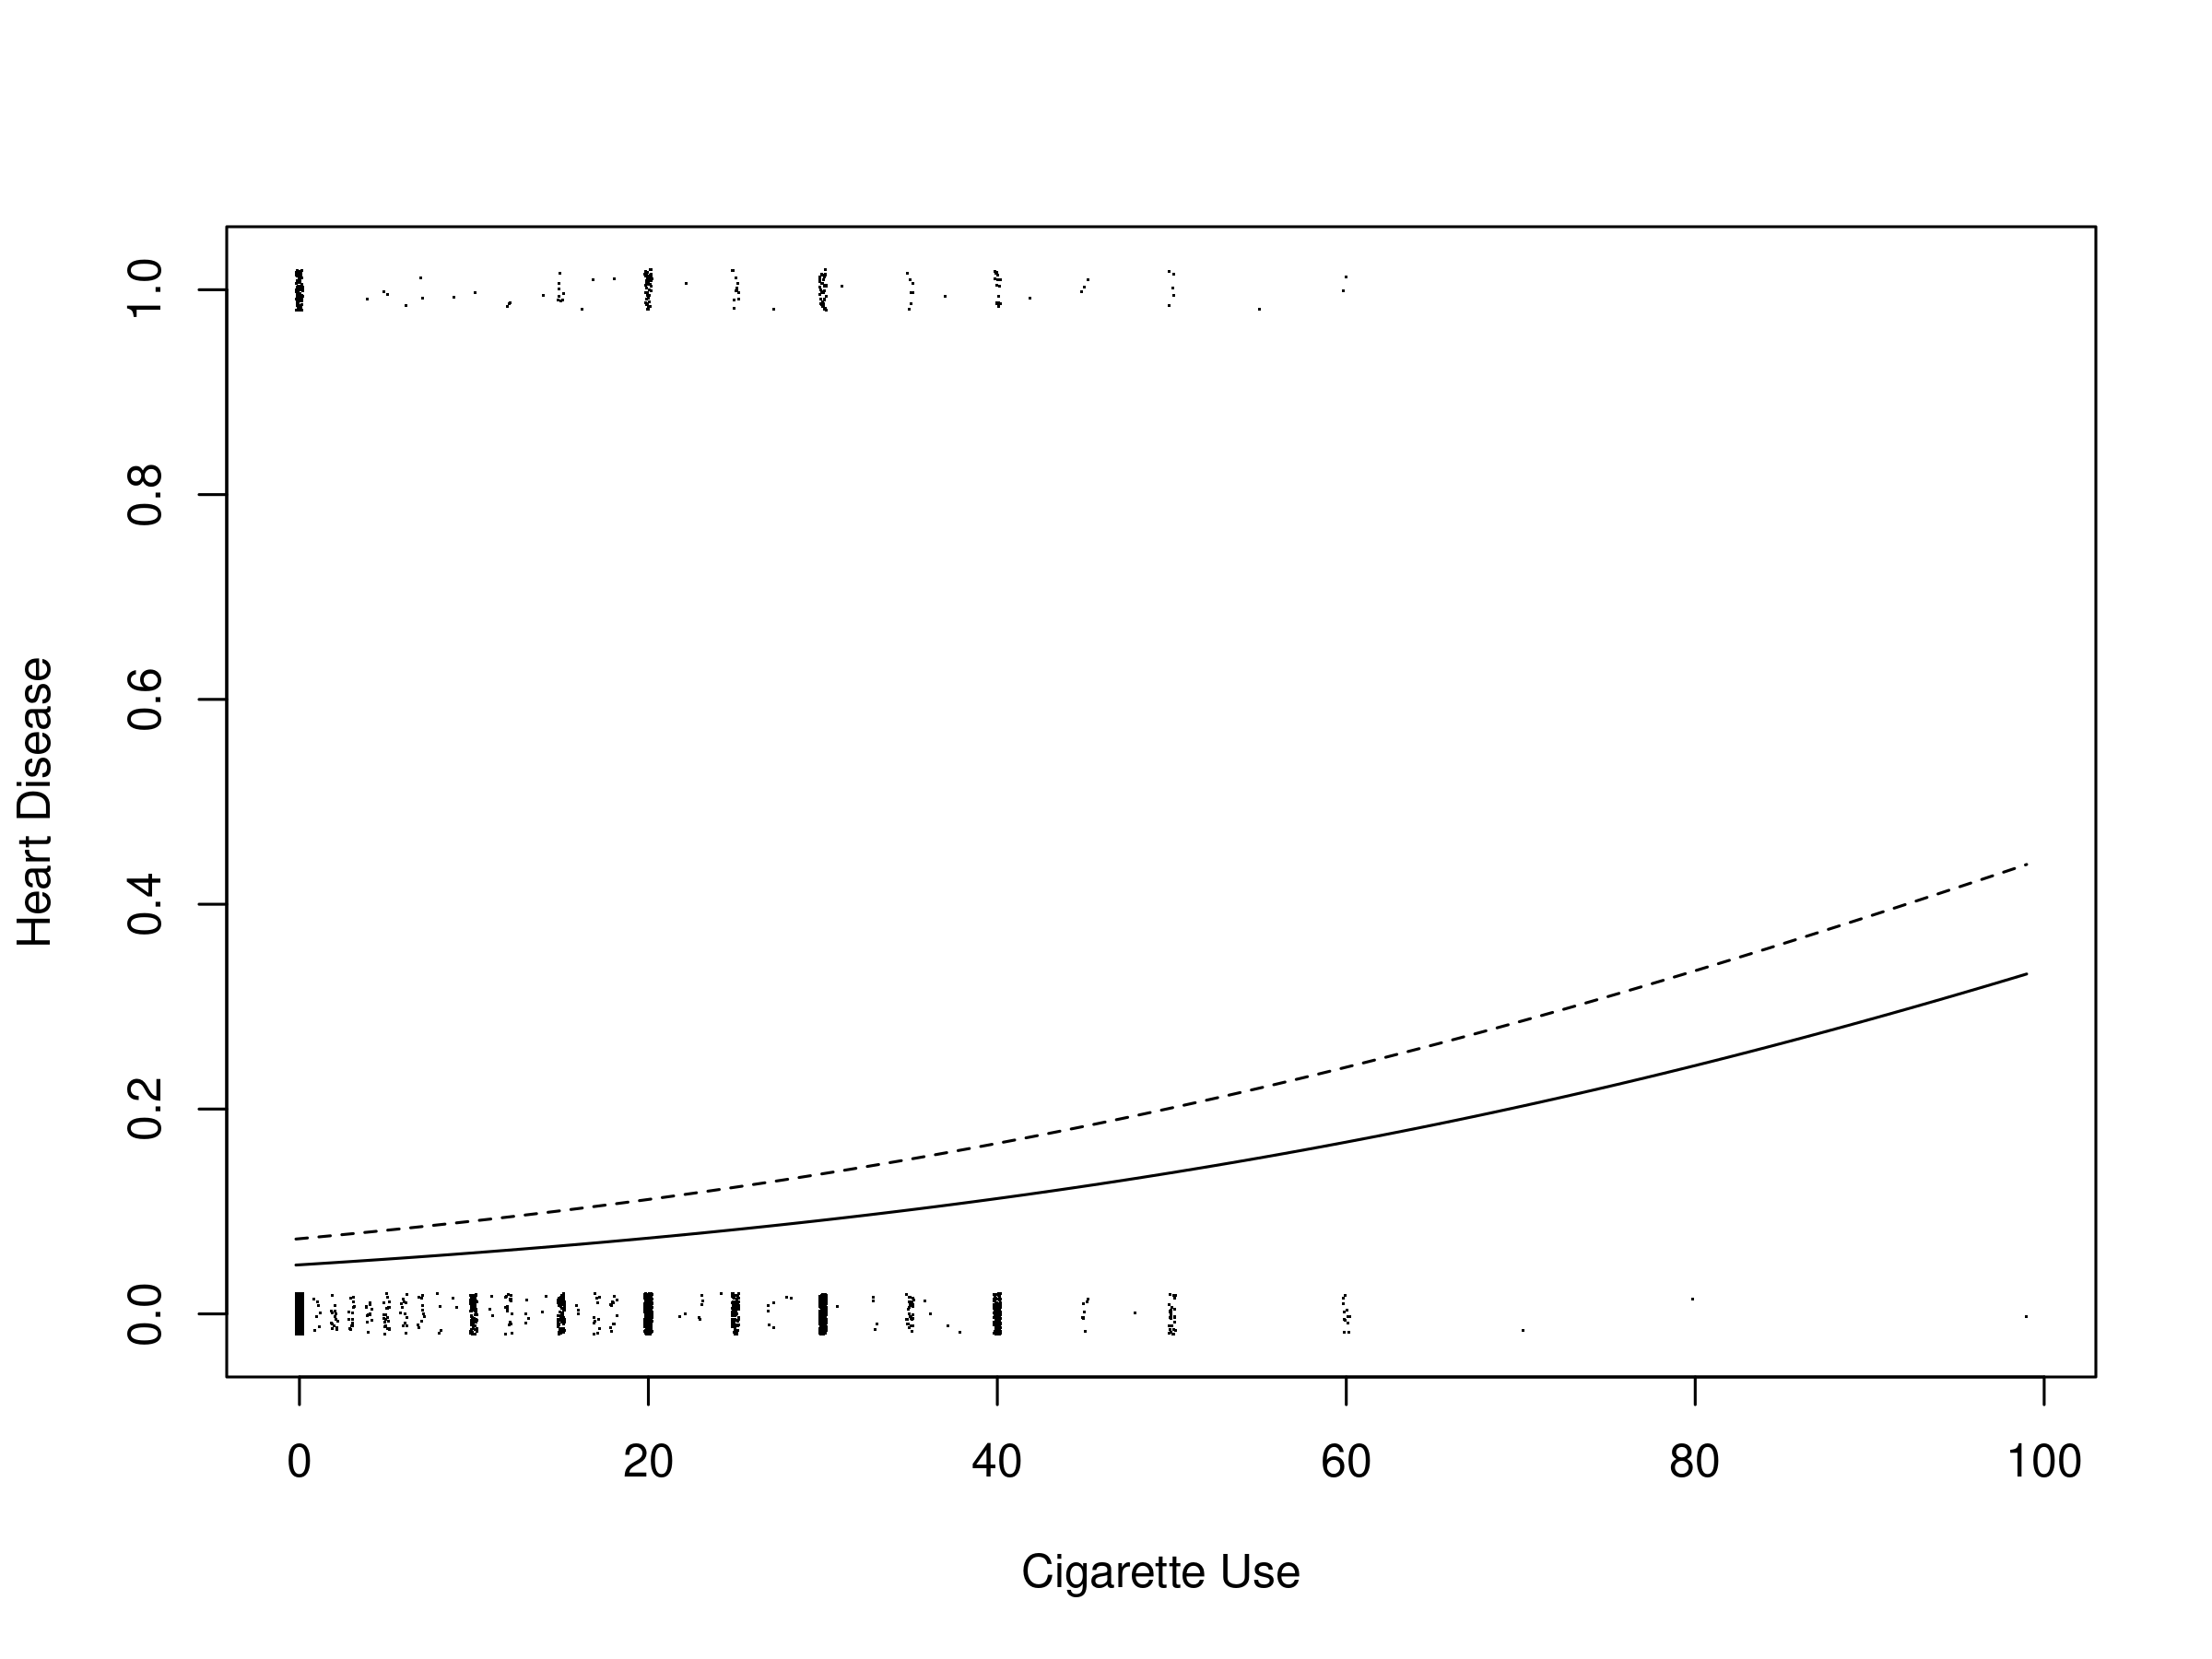

In [13]:
plot(jitter(y,0.1) ~ jitter(cigs), wcgs, xlab="Cigarette Use", ylab="Heart Disease",pch=".")
curve(ilogit(beta[1] + beta[2]*60 + beta[3]*x),add=TRUE)       # predicted curve with short men
curve(ilogit(beta[1] + beta[2]*78 + beta[3]*x),add=TRUE,lty=2) # predicted curve with tall men

- 키 작은 집단과
    - $\hat{\beta}_0 + \hat{\beta}_1 \times 60 + \hat{\beta}_2 \times c$
- 키 큰 집단
    - $\hat{\beta}_0 + \hat{\beta}_1 \times 78 + \hat{\beta}_2 \times c$
- 키에 따라 어떻게 변할까?

계수에 대한 해석은 일반적인 선형모형과 유사하다. 하지만, Y와 직접 연결하여 해석할 수 없고 연결함수와 함께 해석하여함 함을 유의하여라.
- 자세한 해석을 위해

연관성의 방향은 연결함수와 상관없이 할 수 있다.(why?)

### 1.4 오즈 : Interpreting Odds

로지스틱 모형은 의학분야에서 특히 널리 활용된다. 그 이유 중 하나는 오즈값 혹은 오즈비에 대한 해석이 모형으로부터 direct하게 가능하기 때문이다. 오즈값은 chance에 대한 확률의 대체재로 볼 수 있다.

$$Odd=\frac{p}{1−p} ∈(0,∞)$$
- ex) $p=0.8, 1-p=0.2$
    - $\frac{p}{1-p} = \frac{0.8}{0.2} = 4$
    - 이길 확률이 질 확률의 4배
- ex) $p=0.75, 1-p=0.25$
    - $\frac{p}{1-p} = \frac{0.75}{0.25} = 3$
    - 이길 확률이 질 확률의 3배

만약 설명변수가 두 개라면 log-odds는 다음과 같이 표현된다.

$$log(\frac{p}{1−p})=β_0+β_1x_1+β_2x_2$$

때로는 서로 다른 개체들의 오즈값을 비교하고자 한다. 만약, $x_1$이 1단위만큼 변한다면 혹은 $x_1$이 0과 1의 값을 가지는 factor라면 두 경우의 오즈값의 변화는 $exp(β_1)$이 된다.

||$x_1$|$x_2$|
|---|---|---|
|A|65|10|
|B|65|11|

$\log \frac{p_A}{1-p_A} = \beta_0 + \beta_1 10 + \beta_2 65$

$\log \frac{p_B}{1-p_B} = \beta_0 + \beta_1 11 + \beta_2 65$

$\to \log \frac{p_B}{1-p_B} - \log \frac{p_A}{1-p_A} = \beta_1$

$\frac{\frac{p_B}{1-p_B}}{\frac{p_A}{1-p_A}} = exp(\beta_1)$
- $x$가 1 증가했을때 오즈값의 변화

In [14]:
exp(beta)

(Intercept)      height        cigs 
 0.01109108  1.02552819  1.02339691

In [15]:
exp(beta[3]*20)

cigs 
1.588115

이를 일반화하여 오즈비(odds ratio)로 쓰기도 한다.

$$Odds ratio (OR)=\frac{p_1}{1−p_1} \big/ \frac{p_2}{1−p_2}, \begin{cases} 1 & 1\approx2\\ >1 &1>2\\ <1 &1<2\end{cases}$$

오즈비는 다음과 같이 정의되는 상대위험도(relative risk)와는 약간 다르다.

$$Relative risk (RR)=\frac{p_1}{p_2}, \begin{cases} 1 & 1\approx2\\ >1 &1>2\\ <1 &1<2\end{cases}$$

직관적으로는 상대위험도가 이해하기 더 쉽다. 하지만, 이 값은 어떤 실험환경에서는 계산이 불가능하다.
- 코호트 연구
    - 돈, 시간이 많이 든다.
    - 특히 희귀질병은 샘플이 많이 필요하다.
    - 그룹을 나누어 위험도 측정
    - Odds ratio 계산 가능하다.
    - Rerative Risk 계산 가능하다.
- 후향적 연구
    - 나중에 물어보는 연구
    - Rerative Ratio 구하기 힘들다. 제어가 힘들기 때문
    - Odds ratio 계산은 가능

||$x_1$|$x_2$|
|---|---|---|
|A|68|20|
|B|68|0|

In [16]:
c(ilogit(sum(beta*c(1,68,20))),ilogit(sum(beta*c(1,68,0))))

[1] 0.08907868 0.05800425

- 1보다 작네?

In [17]:
ilogit(sum(beta*c(1,68,20)))/ilogit(sum(beta*c(1,68,0)))

[1] 1.535727

- 질병에 걸릴 확률이 담배를20개피 폈을때가 안 폈을때보다 1.5배 정도 높다.
- ilogit 은 logit의 역함수

여기서는 상대위험도와 오즈비의 값이 굉장히 비슷하다. 희박하게 발생하는 사건의 경우 위 두 값은 보통 크게 차이나지 않으나 그렇지 않으면 매우 달라진다.

- 만약, $p_1. p_2$가 작다면? $p_1,p_2 \approx 0$?

$\frac{\frac{p_1}{1-p_1}}{\frac{p_2}{1-p_2}} \approx \frac{p_1}{p_2} \neq \frac{p_1}{p_2}$
- 너무 작으면 값이 비슷하게 나온다. 
- 커지면 비슷하지 않겠지만, 적어도 양/음수는 같다.

In [18]:
p1 = 0.05;p2 = 0.03
p2/p1; (p2/(1-p2))/(p1/(1-p1))

[1] 0.6

[1] 0.5876289

- 비슷하네

In [19]:
p1 = 0.5;p2 = 0.3
p2/p1; (p2/(1-p2))/(p1/(1-p1))

[1] 0.6

[1] 0.4285714

- 점점 차이나기 시작

In [20]:
p1 = 0.95;p2 = 0.97
p2/p1; (p2/(1-p2))/(p1/(1-p1))

[1] 1.021053

[1] 1.701754

- 거의 안 비슷하다고 봐야지.

if $exp(\beta_1)>1$?
- Odds ratio vs Rerative risk
    - $\frac{p_B}{1-p_B} > \frac{p_A}{1-p_A} \therefore p_B > p_A , \beta > 0$ 
    
if $exp(\beta_1)<1$?
- Odds ratio vs Rerative risk
    - $\frac{p_B}{1-p_B} < \frac{p_A}{1-p_A} \therefore p_B < p_A , \beta < 0$ 

Odds ratio 는 Rerative Risk 보다 증폭되는 경향이 있다.

$\frac{p_A}{1-p_A}, p_A = \frac{1}{3}, p_B=\frac{1}{4}, p_A > p_B$
- A가 더 위험하다. 즉, 질병발생 확률이 더 크다.

$\frac{\frac{p_A}{1-p_A}}{\frac{p_B}{1-p_B}} = \frac{\frac{\frac{1}{3}}{\frac{2}{3}}}{\frac{\frac{1}{4}}{\frac{3}{4}}} = \frac{\frac{1}{2}}{\frac{1}{3}} = \frac{3}{2} = 1.5$
- 즉, A의 Odds와 B의 Odds 사이의 ratio
- A의 Odds가 b의 Odds 보다 1.5만큼 크다,

$\frac{p_A}{p_B} = \frac{\frac{1}{3}}{\frac{1}{4}} = \frac{4}{3} = 1.333$
- 원래 1.3배인데 Odds ratio는 1.5?
- 증폭되었네?

if $p_A = p_B$?
- Odds ratio = 1
- Reratve Risk = 1

### 1.5 Inference

추정 이후에는 적절한 통계적 추론 과정이 필요할 수 있다. 이를 위해서는 잔차제곱합을 일반화한 개념이 필요하다. 선형모형에서 잔차제곱합은 다음과 같이 정의되었다.

$$∑^{n}_{i=1}(y_i−\hat{y_i})^2$$
- $s(\beta) \sum^{n}_{i=1}(y_i - X_{i}^{\top} \beta )^2$
- $s(\hat{\beta} = \sum^{n}_{i=1}(y - \hat{y})^2 = \sum^{n}_{i=1} (y-X\beta)^2 = SSE$
- $-2[l_{\mathcal{M}} - l_s] \ge 0$, 단 $l_{\mathcal{M}}\le l_s$

이는 선형모형이 자료를 얼마나 잘 적합하는지를 평가하는 하나의 측도이다. 이를 일반화하여 Deviance라는 개념을 소개한다. 특정 모형$(M)$에 대한 deviance는 다음과 같이 정의된다.
- deviance를 가장 많이 사용하고, deviance가 작을수록 포화모형이다.
- $SSE_s = 0, SSE_\mathcal{M} = \sum^{n}_{i=1} (y_i - \hat{y})^2$

$$D_M=−2 \log \big( \frac{L_{\mathcal{M}}}{L_S} \big)$$
- $-2(\log l_{\mathcal{M}} - \log l_s) \ge 0$
- $L(\hat{\beta}) = l_{\mathcal{M}}$
- $exp(\beta) = l_{\mathcal{M}}$

여기서 $L_{\mathcal{M}}$은 **최대화된 가능도 값**을 의미한다. $L_S$란 **포화모형(Saturated model)에서의 최대화된 가능도 값**을 의미한다. 포화모형이란 자료 하나당 모수를 하나씩 대응시켜 perfect fit을 가져오는 모형을 의미한다. 위 deviance값이 작을 수록 모형의 적합도가 높은 것으로 평가한다. 적절한 가정 하에서 deviance값은 적절한 자유도를 가지는 **카이제곱 분포**로 근사할 수 있는데 이를 이용하여 모형에 대한 유의성 검정을 수행할 수 있게 된다.
- $D_{\mathcal{M}} \sim \chi^2_{(K)}$

참고로 deviance는 오차항이 정규분포인 선형모형에서는 잔차제곱합의 정의와 일치하게 됨이 알려져 있다.

R 결과창에서 `Null deviance` 는 설명변수를 하나도 포함시키지 않은 모형에서의 deviance를 의미하고 `Residual deviance`가 현재 적합된 모형의 deviance를 의미한다. 만약 이 둘 사이에 큰 차이가 있다면 현재 모형이 유의성이 있다는 의미이다 (why?).

In [21]:
1-pchisq(32.2,2)    # differnece between deviances, difference between models

[1] 1.01826e-07

- nulldeviance 17812 - deviance 1749 = 32.2
- 유의미한 변화일까?
- $H_0 : \beta_1 \in \beta_2 = 0$ vs $H_1 : not H_0$

모형은 유의수준 0.05에서 유의하다. 개별변수의 유의성은 anova함수를 이용하여 검정할 수 있다.

In [22]:
lmodc <- glm(chd ~ cigs, family = binomial, wcgs)
anova(lmodc,lmod, test="Chi")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3152,1749.969,NA,NA,NA
2,3151,1749.049,1,0.9202473,0.3374101


- p값은 0.3374로 유의미한 변화(D감소)를 가져오지 않았다.
- 자유도도 1로, 파라메터 차이도 1이다.
- $H_0: \beta_\eta$ vs $H_1 : \beta_\eta \ne 0$

In [23]:
confint(lmod)  # confidence intervals

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-8.13475465,-0.91297018
height,-0.02619902,0.07702835
cigs,0.01514949,0.03100534


### 1.6 Goodness of fit

- logistic의 필수 step은 아니다.
- 가장 잘 적합하는 $\hat{\beta}$ 잘 찾았나? 

In [25]:
library(glmtoolbox)

ERROR: Error in library(glmtoolbox): there is no package called ‘glmtoolbox’


In [26]:
hltest(lmod)

ERROR: Error in hltest(lmod): could not find function "hltest"


- 위 결과 보는데 obserded와 expected 값의 차이가 너무 커서 확인 후 알려주신대~
- p값도 좋지 않았다.(낮았다.)

The logistic model fits data well? : Hosmer-Lemeshow test

https://en.wikipedia.org/wiki/Hosmer%E2%80%93Lemeshow_test

### 1.7 Other link functions

로지스틱 모형이 가장 폭넓게 쓰이지만 다른 연결함수들을 고려할 수도 있다. 단, 연결함수는 다음의 성질을 만족해야 할 것이다.

- 증가함수
- 적절한 range를 보장
    - $g(0,1) \to \cal{R}$ 실수 전체를 아우르면 좋겠다.

대체연결함수로 사용할 수 있는 것들에는 다음이 있다.

- Probit : $g=Φ^{−1}(p) , Φ : N(0,1)$의 CDF.
    - CDF $Φ: \cal{R} \to (0,1)$
    - $Φ^{-1} : (0,1) \to \cal{R}$
- Complementary log-log : $g=log(−log(1−p))$.
    - $g(0,1) \to \cal{R}$
- Cauchit : $g=\tan(π(p−0.5))$

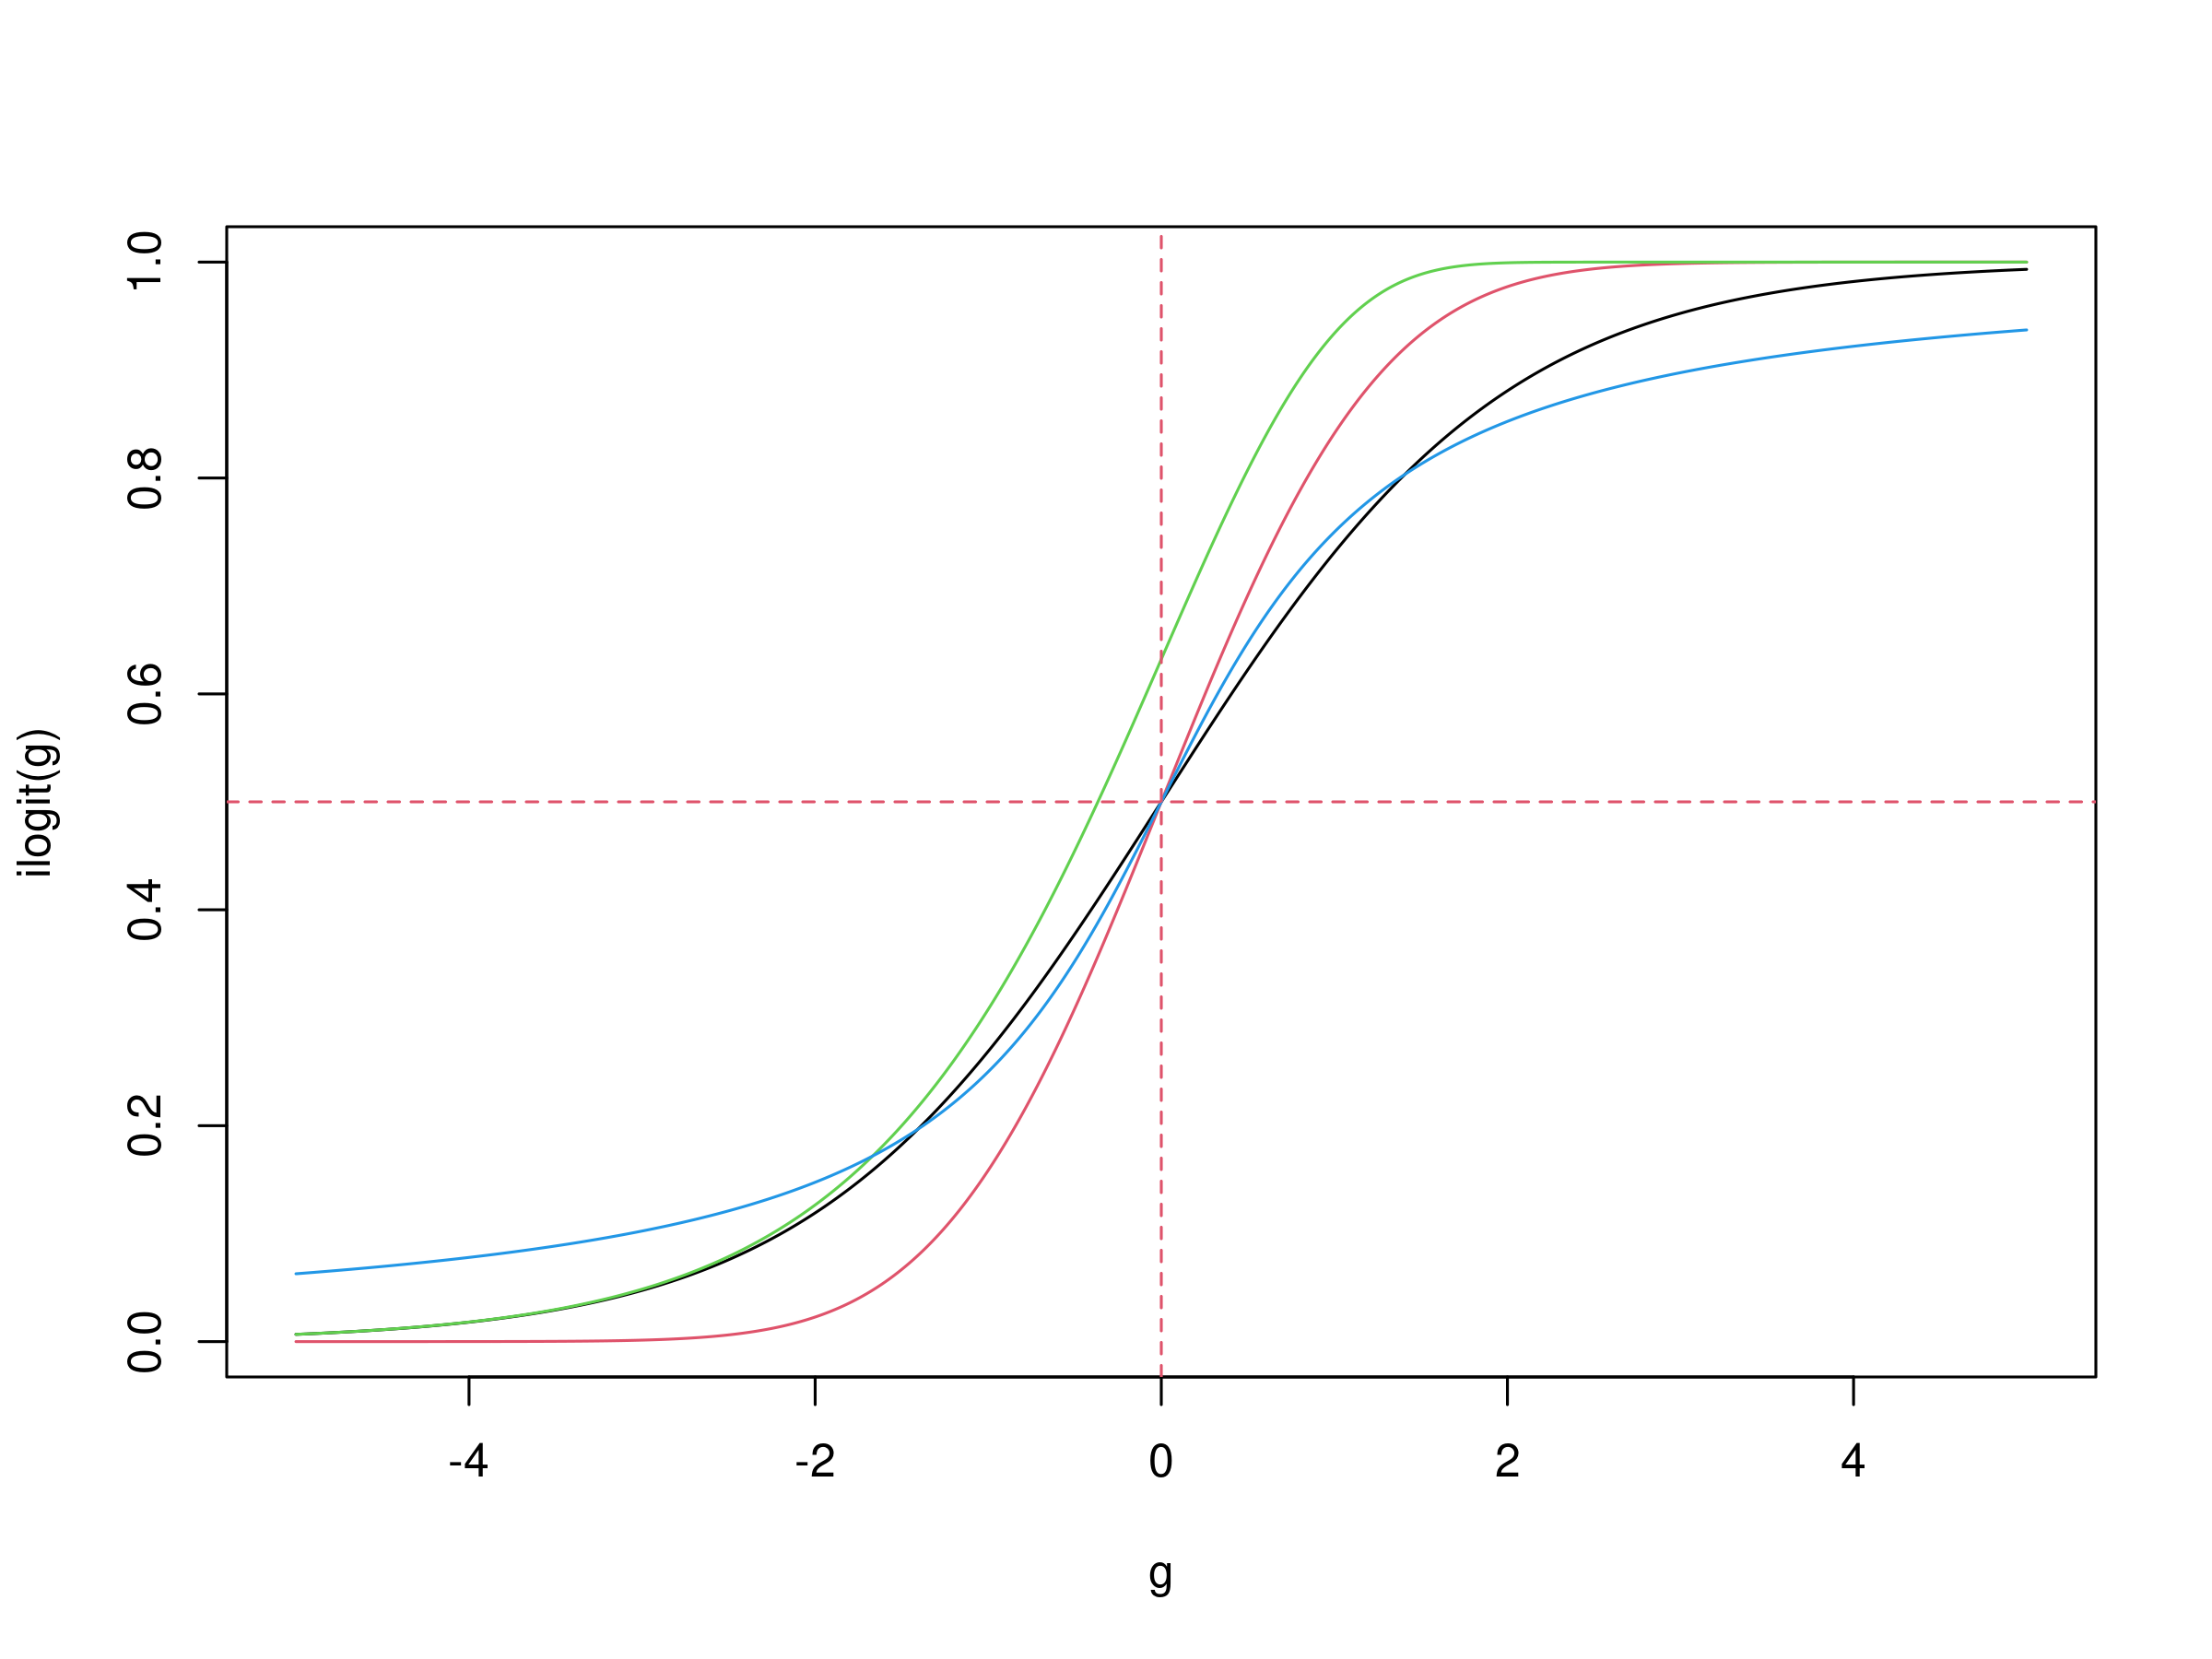

In [27]:
g = seq(-5,5,0.01)
plot(g,ilogit(g),type="l")
lines(g,pnorm(g),col=2)
lines(g,1-exp(-exp(g)),col=3)
lines(g,atan(g)/pi + 0.5,col=4)
abline(v=0,h=0.5,col=2,lty="dashed")

- 어떤 link function을 사용해야 하는가? 답은 없다.
- 검은색 선: logit link
    - 점(0,0.5)에 대해 대칭
- 빨간색 선: Probit : $Φ^{-1}(p_i) = Φ(X_i \beta)$
    - 점(0,0.5)에 대해 대칭
- 파란색 선: Cauchit
    - 점(0,0.5)에 대해 대칭
- 연두색 선: Complementary log-log : $g=log(−log(1−p))$
    - 빨리 증가 -> 천천히 증가
    - 연두색 선만 대칭이 아닌 것을 확인 할 수 있다.
    - 약물 반응 등

어떤 연결함수를 사용할지는 몇 가지 요소에 따라 결정할 수 있지만 정해진 답은 없다. 로지스틱 모형이 가장 널리 쓰이기는 하지만 상황에 따라 다른 모형을 더 자연스럽게 받아들이는 분야도 존재하며 조금 더 확장된 모형을 사용하는 경우에는 특정 연결함수를 사용하는 것이 필요할 수 있다.

한 가지 기억할 것은 cloglog 연결함수는 대칭성질을 가지지 않는다는 점이다.

In [28]:
lmod_l <- glm(chd ~ cigs + height, family = binomial, wcgs)
lmod_c <- glm(chd ~ cigs + height, family = binomial(link = cloglog), wcgs)
lmod_p <- glm(chd ~ cigs + height, family = binomial(link = probit), wcgs)
summary(lmod_l)


Call:
glm(formula = chd ~ cigs + height, family = binomial, data = wcgs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0041  -0.4425  -0.3630  -0.3499   2.4357  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.50161    1.84186  -2.444   0.0145 *  
cigs         0.02313    0.00404   5.724 1.04e-08 ***
height       0.02521    0.02633   0.957   0.3383    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1781.2  on 3153  degrees of freedom
Residual deviance: 1749.0  on 3151  degrees of freedom
AIC: 1755

Number of Fisher Scoring iterations: 5


- Complementary log-log

In [29]:
summary(lmod_c)


Call:
glm(formula = chd ~ cigs + height, family = binomial(link = cloglog), 
    data = wcgs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0526  -0.4414  -0.3641  -0.3509   2.4336  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.480764   1.758523  -2.548   0.0108 *  
cigs         0.021694   0.003772   5.751 8.88e-09 ***
height       0.024542   0.025133   0.976   0.3288    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1781.2  on 3153  degrees of freedom
Residual deviance: 1749.3  on 3151  degrees of freedom
AIC: 1755.3

Number of Fisher Scoring iterations: 5


- prob

In [30]:
summary(lmod_p)


Call:
glm(formula = chd ~ cigs + height, family = binomial(link = probit), 
    data = wcgs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9422  -0.4451  -0.3611  -0.3482   2.4402  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.383904   0.913082  -2.611  0.00903 ** 
cigs         0.011902   0.002091   5.692 1.26e-08 ***
height       0.011872   0.013060   0.909  0.36332    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1781.2  on 3153  degrees of freedom
Residual deviance: 1748.7  on 3151  degrees of freedom
AIC: 1754.7

Number of Fisher Scoring iterations: 5


- estimate값이 달라졌다?
    - 하지만 실제로 probability를 다르게 주진 않았다.
- 적합도가 `1748.7`로 가장 좋다고 볼 수 있지만. 소수점 차이 밖에 나지 않았다.
- 적합도 좋은 것을 찾는게 좋으나, 큰 차이게 없다면 logistic을 쓰자!